In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from fig_config import figure_features, add_grid
import scipy

In [65]:
# Function to plot histogram of a given property (first argument of the function)
# arguments: property, x label, range
def plot_hist(v,xl,r):
  
  plt.hist(v,bins=50,histtype='step', range=r, color='blue', label='Signal')
  plt.xlabel(xl,fontsize=25)
  plt.ylabel('Hits',fontsize=25)

In [66]:
# Function to compare histograms of signal and background
# By default, histograms are normalized to unit area
def compare_dist(s,b,xl,r,d=True,l=0):
  
    # arguments: signal, background, x label, range, density/counts (optional), log scale (optional)
    labels = ['Signal', 'Background']
    data   = [s, b]
    color = ['r','b']
    plt.legend(labels)
    plt.hist(data,bins=50,density=d,histtype='step',label=labels, range=r, log=0, color=color)
    plt.xlabel(xl,fontsize=25)
    if d:
        plt.ylabel('Density',fontsize=25)
    else:
        plt.ylabel('Hits',fontsize=25)

    handle1 = matplotlib.lines.Line2D([], [], c='r')
    handle2 = matplotlib.lines.Line2D([], [], c='b')
    leg = plt.legend(handles=[handle1, handle2],labels=labels)

    # change the line width for the legend
    for line in leg.get_lines():
        line.set_linewidth(3.0)

In [67]:
def get_data(data, nb, r):
    return np.histogram(data, bins=nb, range=r)

In [68]:
def compare_data_sim(d,b,s,lumH,xl,r,l=0):
  # arguments: data, background, signal, signal luminosity, x label, range, log scale (optional)
  # data
  counts, bins = np.histogram(d,bins=80, range=r)
  errors = np.sqrt(counts)
  plt.errorbar(bins[:-1],counts, yerr=errors, fmt='.k', label='Data');

  # signal + background simulation normalized to data
  wgts_b = (lumData/lumZj)*np.ones_like(b)
  counts_b, bins_b = np.histogram(b,bins=80, range=r, weights=wgts_b)
  wgts_s = (lumData/lumH)*np.ones_like(s)
  counts_s, bins_s = np.histogram(s,bins=80, range=r, weights=wgts_s)

  # signal + background
  plt.plot(bins[:-1],counts_b+counts_s, label='signal + background', color='black', alpha=1)
  # only signal
  plt.plot(bins[:-1],counts_s, label='signal', color='blue')
  # only background
  plt.plot(bins[:-1],counts_b, label='background', color='yellow', alpha=1)

  if l==1: 
    plt.yscale('log', nonpositive='clip')

  plt.xlabel(xl,fontsize=25)
  plt.ylabel('Hits',fontsize=25)
  
  plt.legend()


  # obtenemos numero de eventos en 2 sigmas de señal
  M = bins[np.where(counts_s==max(counts_s))]
  sigma = 50
  bins = bins[:-1]

  aux = np.where( ((bins < M+2*sigma)&(bins > M-2*sigma)), bins, 0 ) #every element out of the range will be subtituted by 0
  aux2 = aux[aux != 0] #remove zeros -> yields mass range

  # obtenemos los hits en el rango
  hits = np.array(counts_s) * aux #elements to be droped will be zero
  hits = hits[hits != 0] #remove zeros
  hits = np.array(hits) / np.array(aux2) #divide by the previous multiplying factor

  np.sum(hits)

  
  return len(d), np.sum(hits)

In [69]:
def plot_data(v,xl,r,l=0):
  # arguments: variable, x label, range, log scale (optional)
  counts, bins = np.histogram(v,bins=80, range=r)
  errors = np.sqrt(counts)
  plt.errorbar(bins[:-1],counts, yerr=errors, fmt='.k', label='Data');
  if l==1: 
    plt.yscale('log', nonpositive='clip')
  plt.xlabel(xl,fontsize=25)
  plt.ylabel('Hits',fontsize=25)

In [70]:
def plotCutSignificance(s, b, var, r, ns, mode, Hmass, Hwidth, lumH):
  # arguments: signal data, background data, variable name, range, number of steps, 
  #            mode (>=0 cut larger than; <0 cut smaller than), Higgs mass hypothesis, Width around Higgs mass, Lumi Higgs signal
  #            example: plotCutSignificance(Higgs350, ZJets, 'ptl1', (0,200), 20, 1, 350, 50, lumH350)
  SigSel=s.loc[(abs(s.masslljj-Hmass)<Hwidth), var]
  BckSel=b.loc[(abs(b.masslljj-Hmass)<Hwidth), var]
  wgts_s = (lumData/lumH)*np.ones_like(SigSel)
  ys, xs = np.histogram(SigSel, bins=ns, range=r, weights=wgts_s) # signal events within Hmass and normalized to luminosity in data
  wgts_b = (lumData/lumZj)*np.ones_like(BckSel)
  yb, xb = np.histogram(BckSel, bins=ns, range=r, weights=wgts_b) # Backg. events within Hmass and normalized to luminosity in data
  signif=[]
  for i in range(ns):  
    if mode>=0:  # cut will be greater than
      Nsig = ys[i:ns].sum()
      Nbck = yb[i:ns].sum()
    else:
      Nsig = ys[0:i].sum()
      Nbck = yb[0:i].sum()
    sig = Nsig/np.sqrt(Nbck) if Nbck>0 else 0
    signif.append(sig)
  
  print(var+' óptima : ', xs[int(np.squeeze(np.where(signif==max(signif))))])
  figure_features()
  plt.plot(xs[:-1],signif,'bo',markersize=3.5)
  plt.ylabel("Significance",fontsize=25)
  plt.xlabel(var,fontsize=25)
  plt.grid()
  plt.show()

In [71]:
def plotCutSignificanceCentral(s, b, var, central, width, ns, Hmass, Hwidth, lumH):
  SigSel=s.loc[(abs(s.masslljj-Hmass)<Hwidth), var]
  BckSel=b.loc[(abs(b.masslljj-Hmass)<Hwidth), var]
  wgts_s = (lumData/lumH)*np.ones_like(SigSel)
  ys, xs = np.histogram(SigSel, bins=2*ns, range=(central-width, central+width), weights=wgts_s) 
  wgts_b = (lumData/lumZj)*np.ones_like(BckSel)
  yb, xb = np.histogram(BckSel, bins=2*ns, range=(central-width, central+width), weights=wgts_b) 
  signif=[]
  cutwidth=[]
  for i in range(ns):  
    Nsig = ys[ns-i-1:ns+i].sum()
    Nbck = yb[ns-i-1:ns+i].sum()
    sig = Nsig/np.sqrt(Nbck) if Nbck>0 else 0
    signif.append(sig)
    cutwidth.append((i+1)*width/ns)
  plt.plot(cutwidth,signif,'bo',markersize=3.5)
  plt.xlabel("Cutwidth",fontsize=25)
  plt.ylabel("Significance",fontsize=25)
  plt.grid()
  plt.show()

In [72]:
#MÉTODO SIMPSON ADAPTADO Copiado de Luis Manuel

def simp_int(f, param, a, b, error): 

    objetivo = error #error requerida
    
    h=(b-a)/2

    # calculamos la integral para N=2
    S = (f(a, *param)+f(b, *param))/3
    T = 2*f(a+h, *param)/3
    I1 = h*(S+2*T)

    # calculamos la integral para N = 4
    h /= 2
    S += T
    T = 2*(f(a+h, *param)+f(a + 3*h, *param))/3
    I2 = h*(S+2*T)

    # calculamos el error
    err = abs(I2-I1)/15
    N=4
    #print("N=",N,"I=",I2,"error=",err)

    # bucle principal
    while err>=objetivo:
        #Calculamos la nueva estimación de la integral
        N *= 2
        h /= 2
        I1 = I2
        S += T
        T = 0.0
        for k in range(1,N,2):
            T += 2*f(a+k*h, *param)/3
        I2 = h*(S+2*T)
        # Calculamos la nueva estimación del error
        err = abs(I2-I1)/15
        #print("N=",N,"I=",I2,"error=",err)

    return I2

In [10]:
def cross_section(N_signal):
    return N_signal / (L * B * epsilon)

In [74]:
dir = "Datos/"
ZJets    = pd.read_csv(dir+'ZJets.csv')
Higgs350 = pd.read_csv(dir+'Higgs2L2Q_M350.csv')
Higgs400 = pd.read_csv(dir+'Higgs2L2Q_M400.csv')
Higgs500 = pd.read_csv(dir+'Higgs2L2Q_M500.csv')
Data     = pd.read_csv(dir+'Real-Data.csv')

## A - Estudio de datos de simulaciones Monte Carlo:

## A - 1 : Estudio de fondo y señal caracteristica

Los huecos en la rapidity en 1.5 pueden deberse a que las camaras de deriva dejan un hueco en ese angulo. Ver diapos de Isabel Josa.

## LEPTONES

Distribuciones cinemáticas - MOMENTO TRANSVERSO LEPTON 1

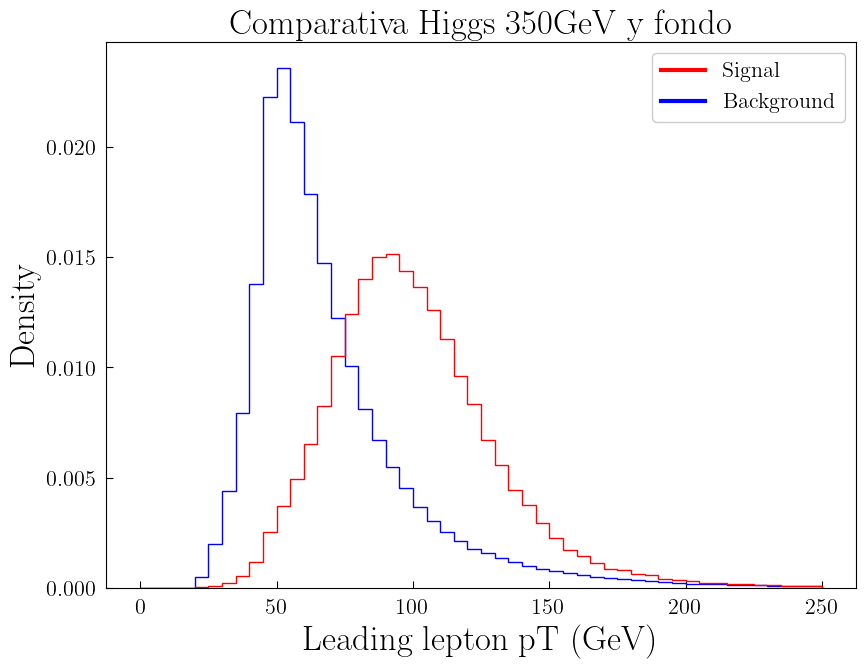

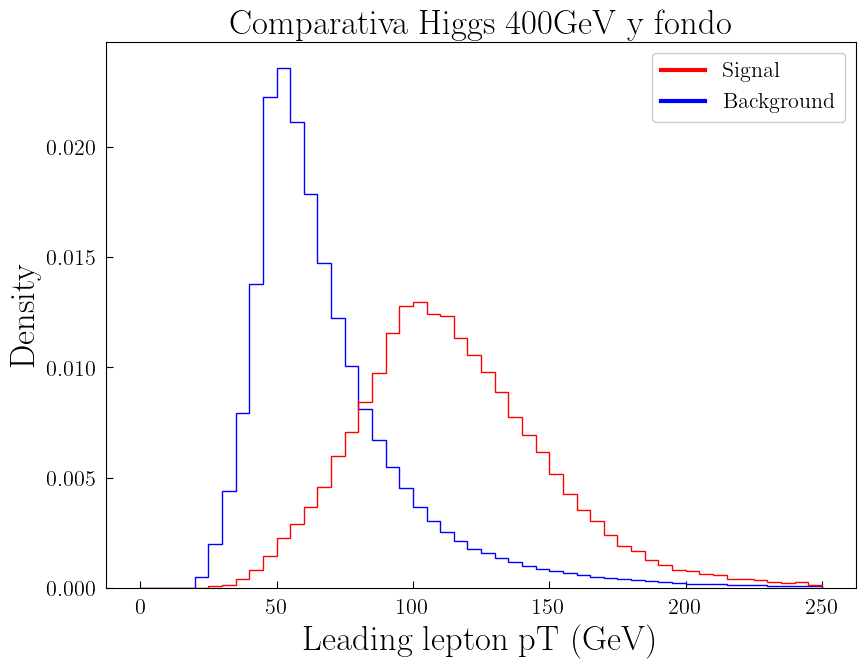

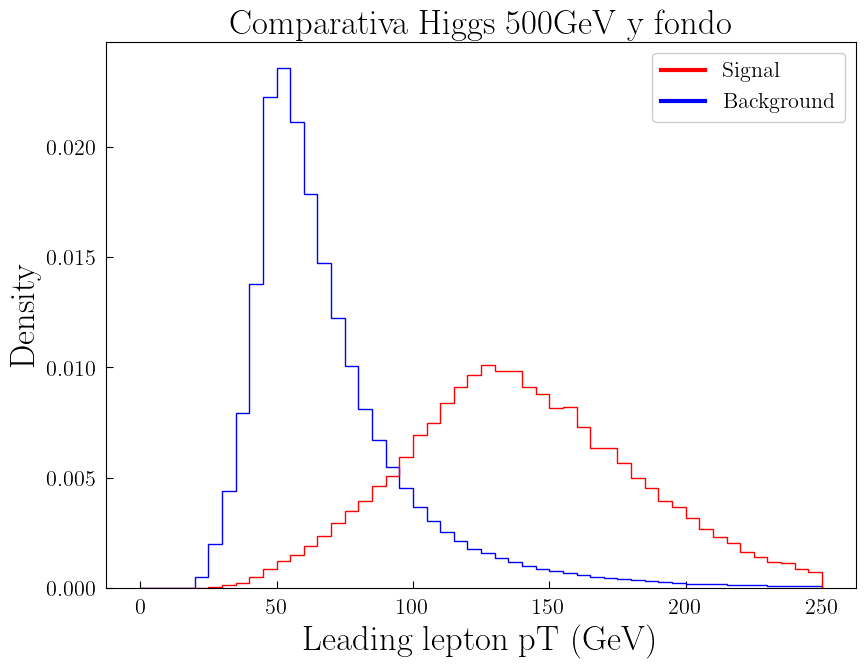

In [75]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.ptl1, ZJets.ptl1, 'Leading lepton pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss350pt1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.ptl1, ZJets.ptl1, 'Leading lepton pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss400pt1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.ptl1, ZJets.ptl1, 'Leading lepton pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss500pt1_fondo.png")
plt.show()

Distribuciones cinemáticas - MOMENTO TRANSVERSO LEPTON 2

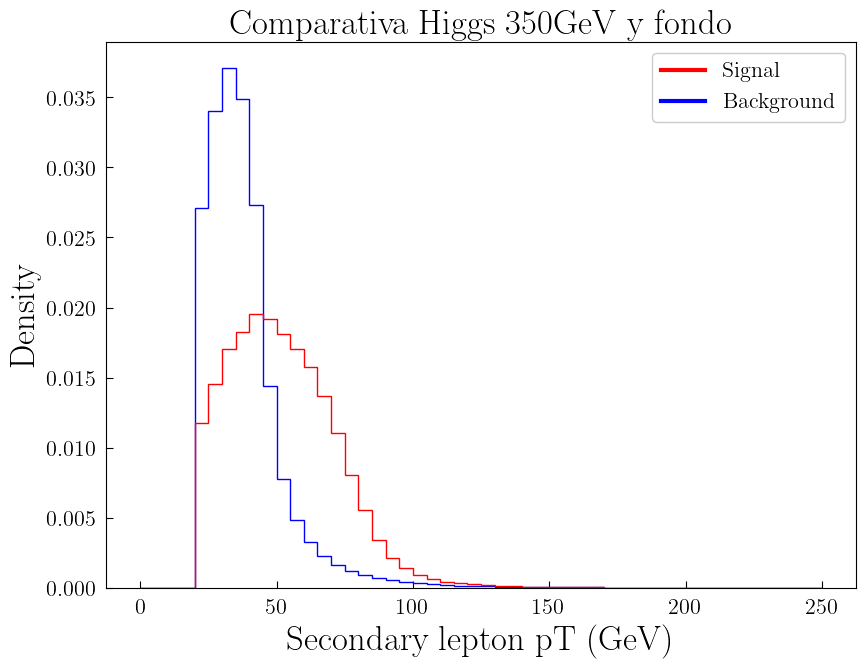

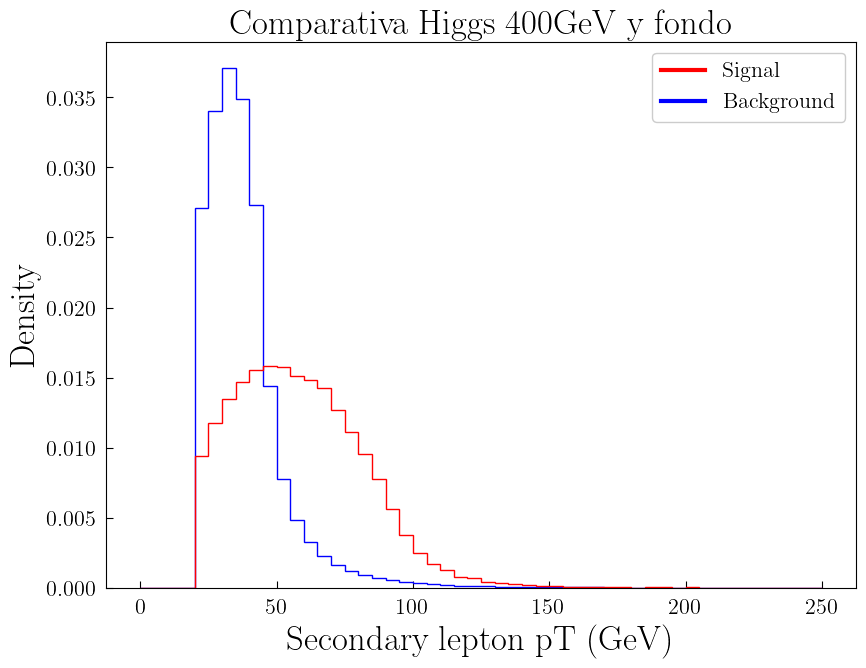

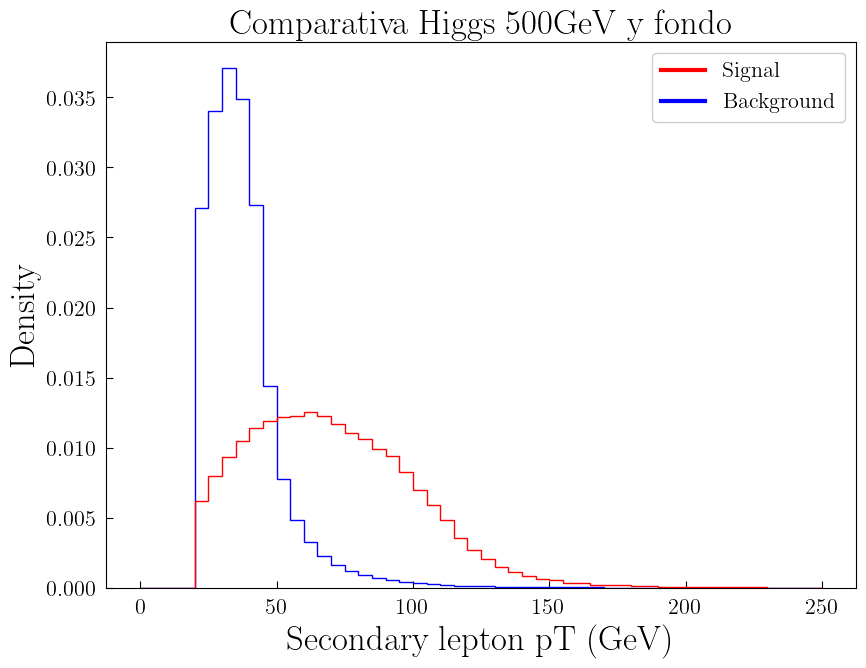

In [76]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.ptl2, ZJets.ptl2, 'Secondary lepton pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss350pt2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.ptl2, ZJets.ptl2, 'Secondary lepton pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss400pt2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.ptl2, ZJets.ptl2, 'Secondary lepton pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss500pt2_fondo.png")
plt.show()

Distribuciones cinemáticas - PSEUDORAPIDITY LEPTON 1

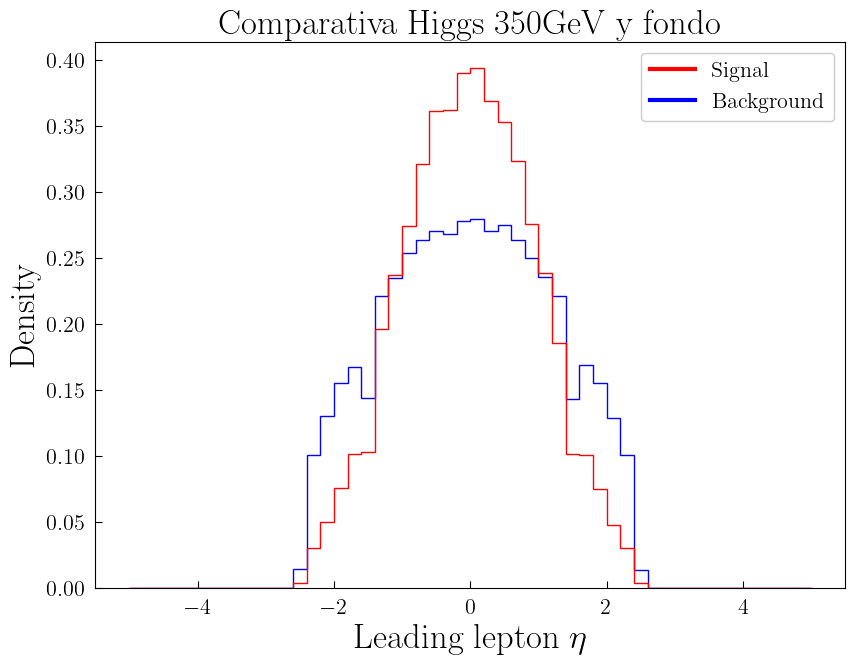

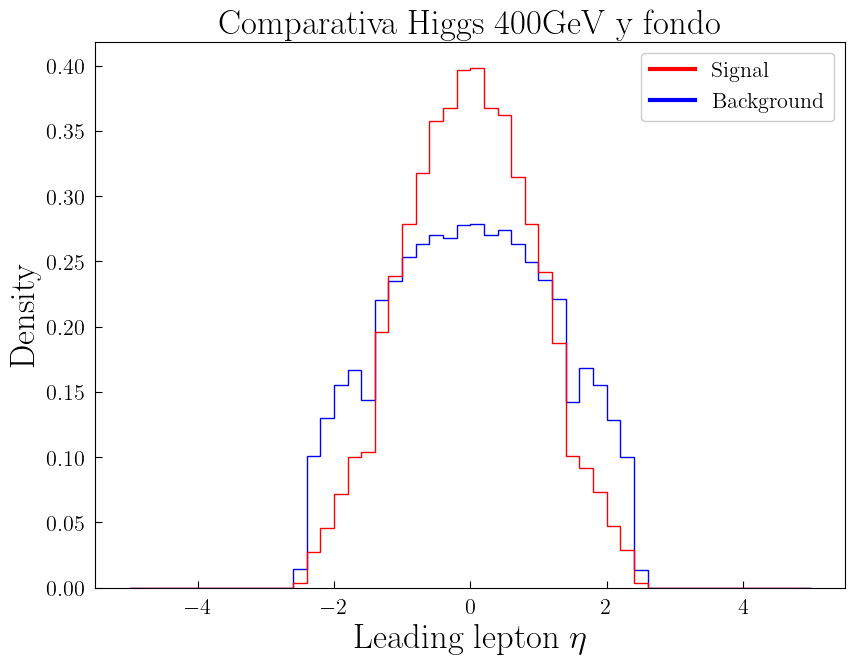

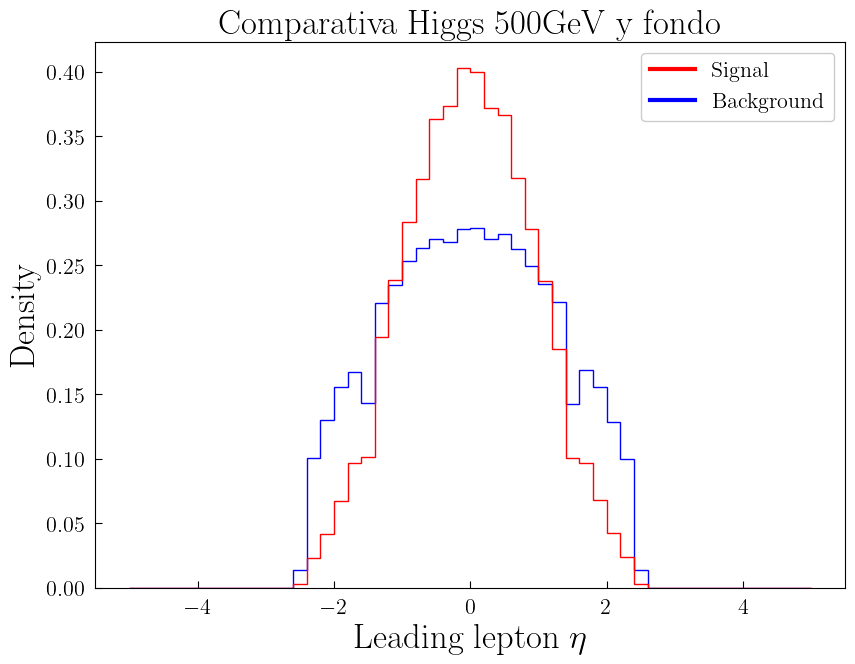

In [77]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.etal1, ZJets.etal1, 'Leading lepton '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
#plt.xscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss350eta1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.etal1, ZJets.etal1, 'Leading lepton '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
#plt.xscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss400eta1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.etal1, ZJets.etal1, 'Leading lepton '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
#plt.xscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss500eta1_fondo.png")
plt.show()

Distribuciones cinemáticas - PSEUDORAPIDITY LEPTON 2

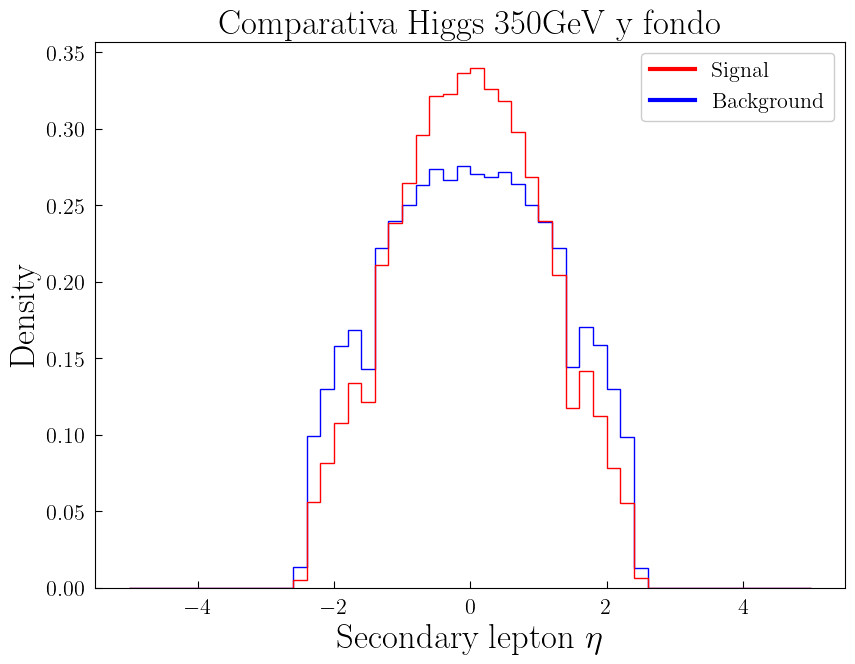

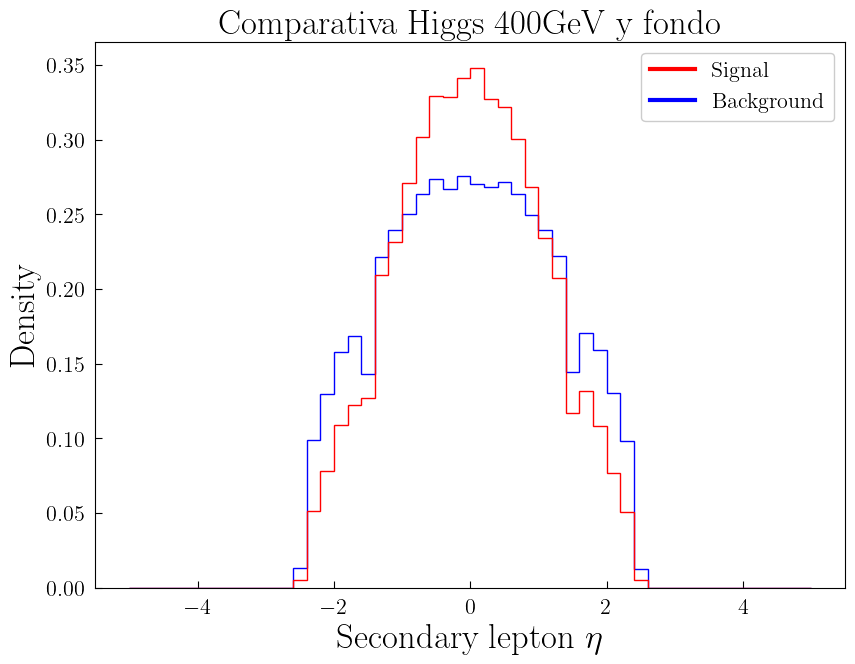

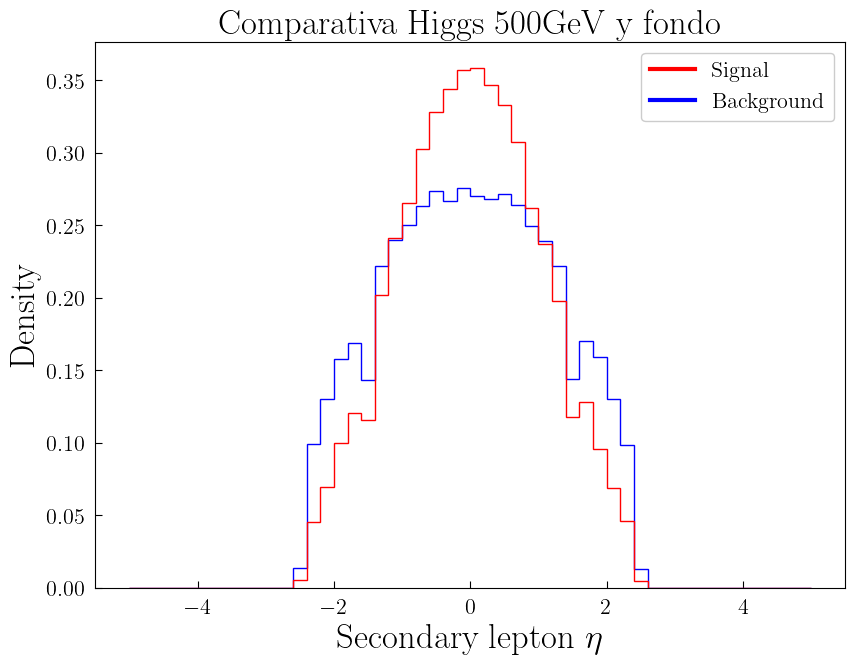

In [78]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.etal2, ZJets.etal2, 'Secondary lepton '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss350eta2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.etal2, ZJets.etal2, 'Secondary lepton '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss400eta2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.etal2, ZJets.etal2, 'Secondary lepton '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss500eta2_fondo.png")
plt.show()

Distribuciones cinemáticas - ANGULO ACIMUTAL LEPTON 1

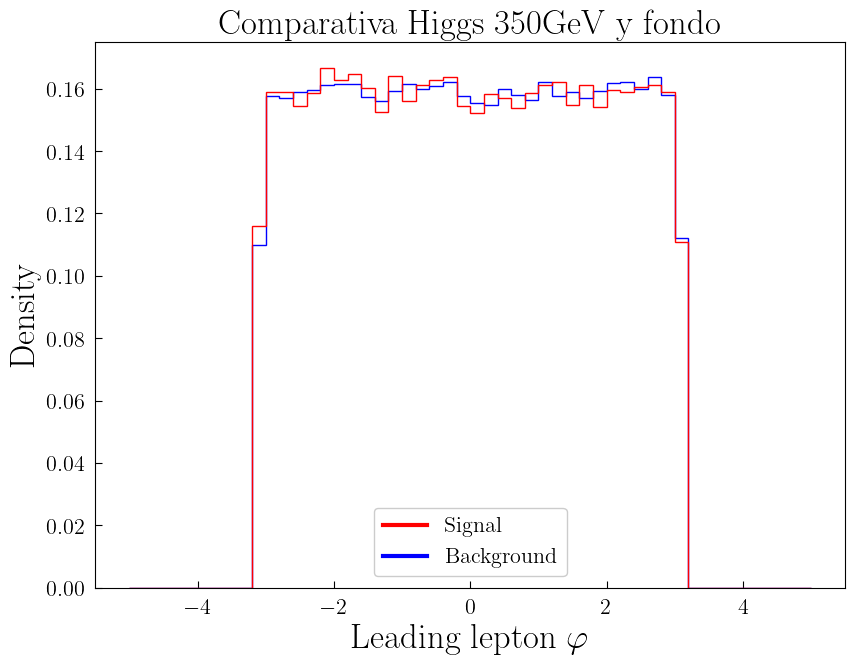

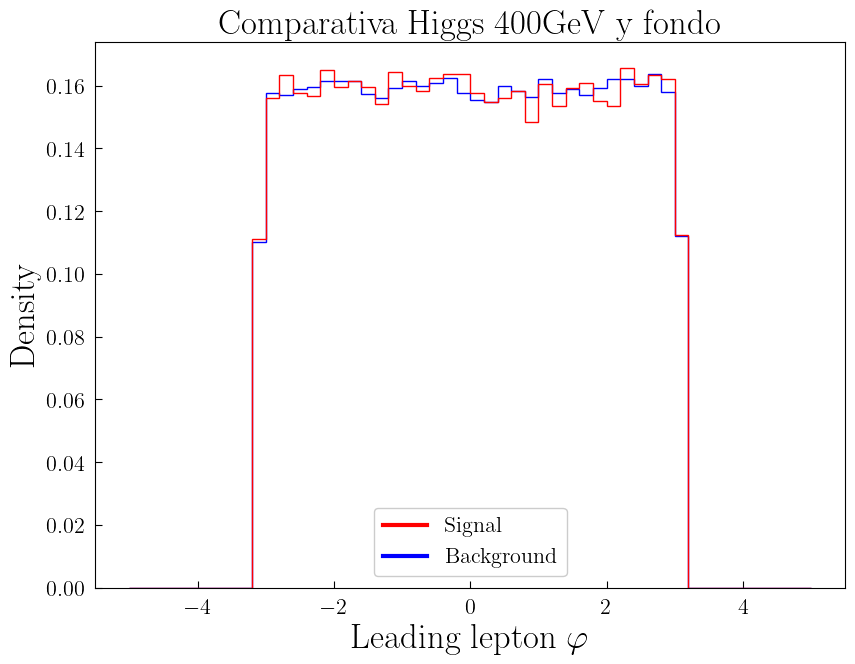

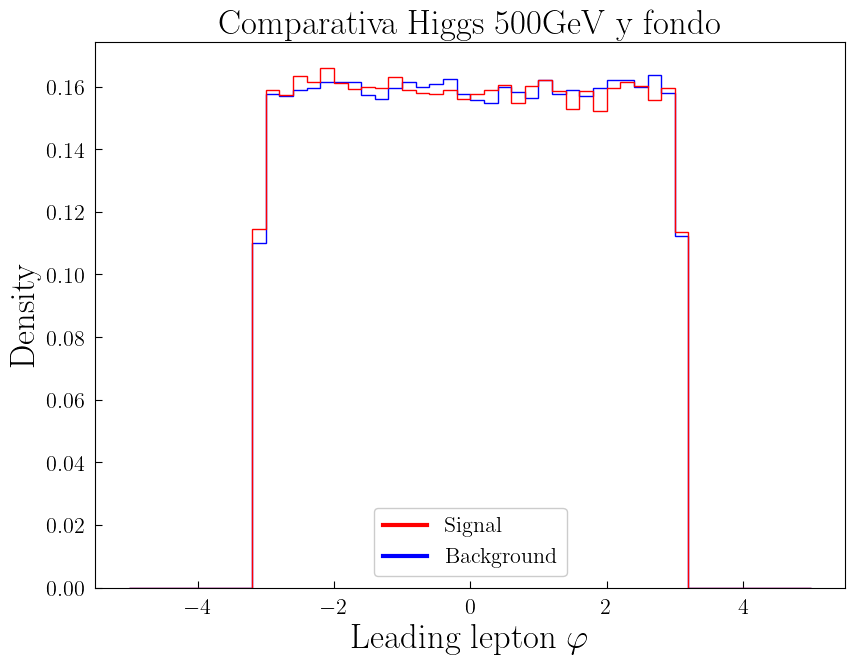

In [79]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.phil1, ZJets.phil1, 'Leading lepton '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss350phi1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.phil1, ZJets.phil1, 'Leading lepton '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss400phi1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.phil1, ZJets.phil1, 'Leading lepton '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss500phi1_fondo.png")
plt.show()

Distribuciones cinemáticas - ANGULO ACIMUTAL LEPTON 2

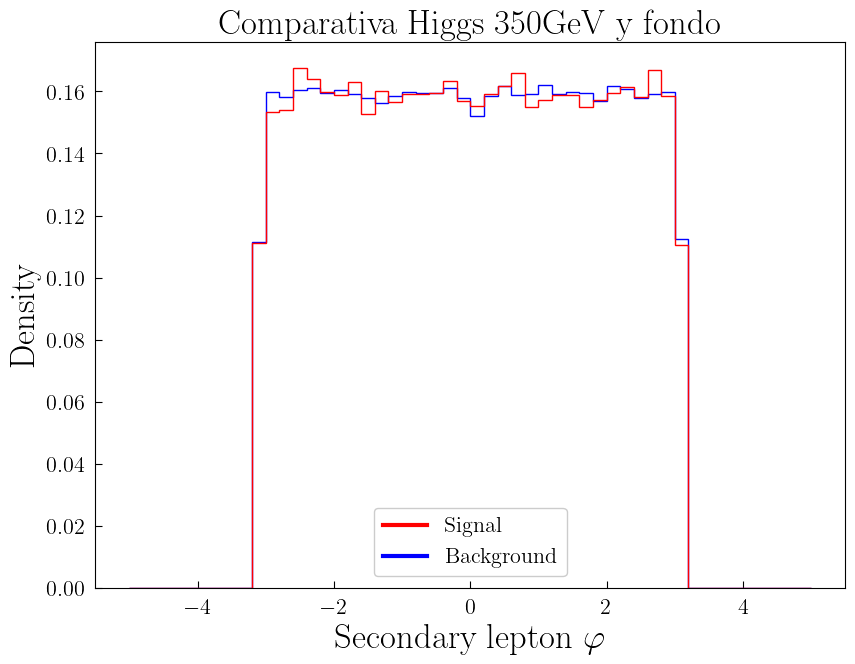

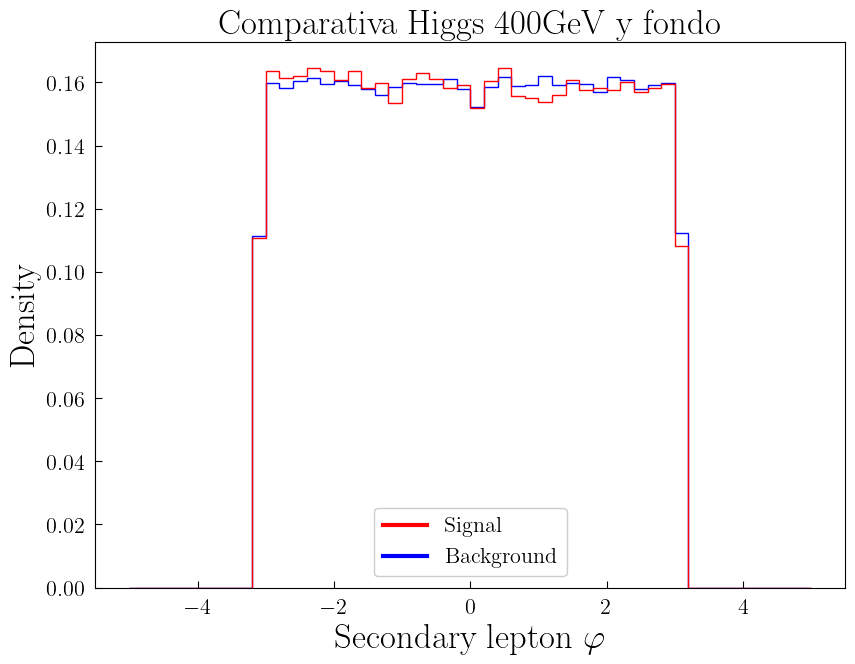

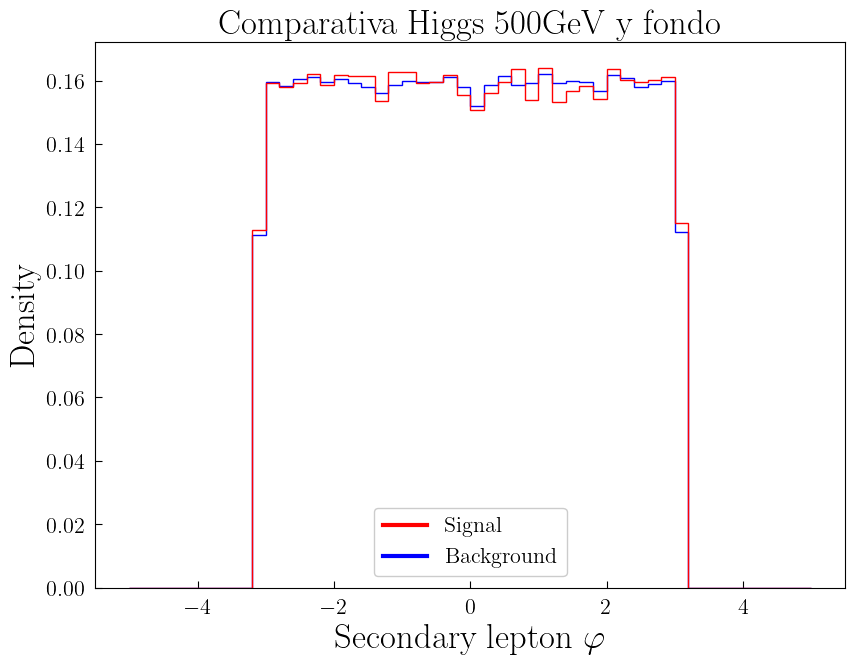

In [80]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.phil2, ZJets.phil2, 'Secondary lepton '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss350phi2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.phil2, ZJets.phil2, 'Secondary lepton '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss400phi2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.phil2, ZJets.phil2, 'Secondary lepton '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Leptones/Comparativa_Higss500phi2_fondo.png")
plt.show()

## JETS

Distribuciones cinemáticas - MOMENTO TRANSVERSO JET 1

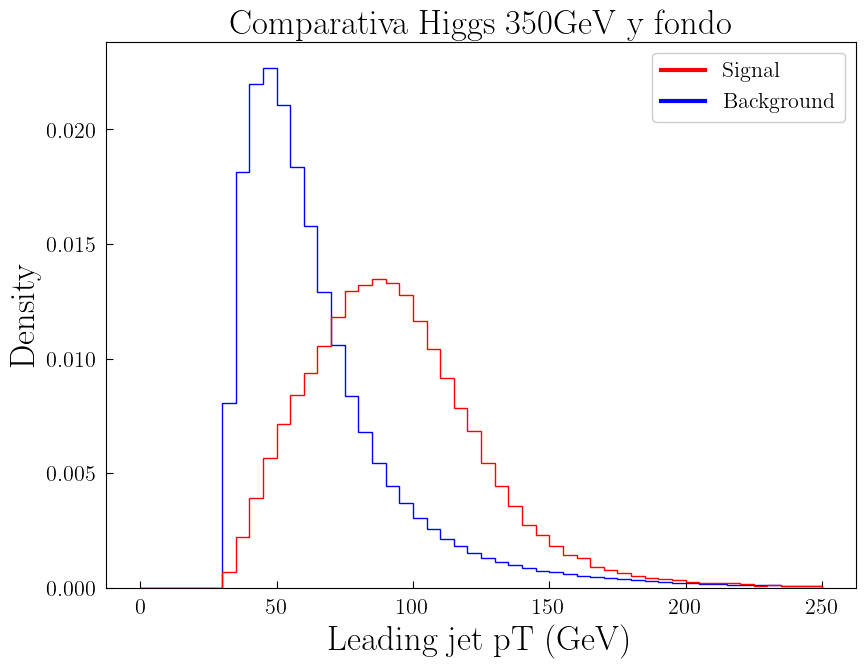

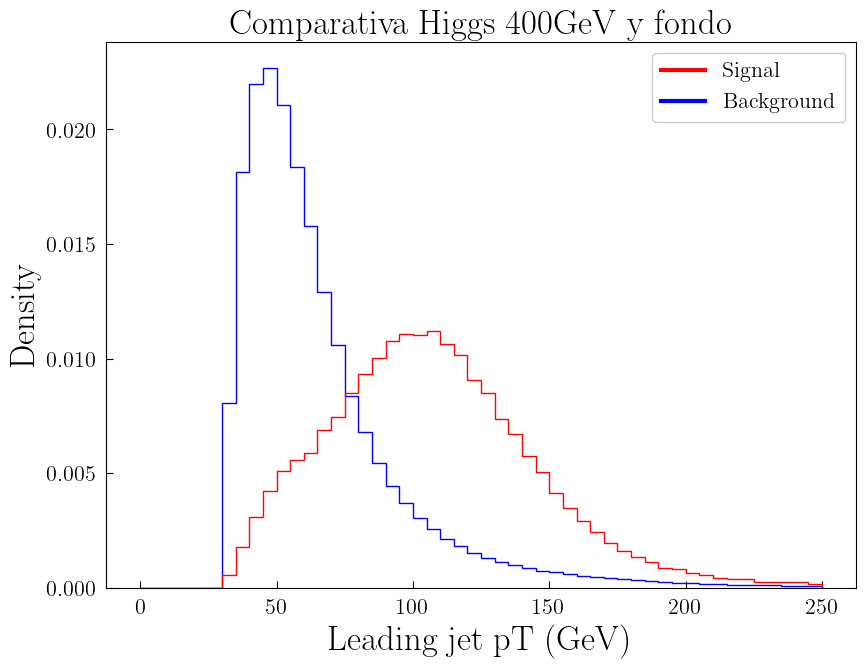

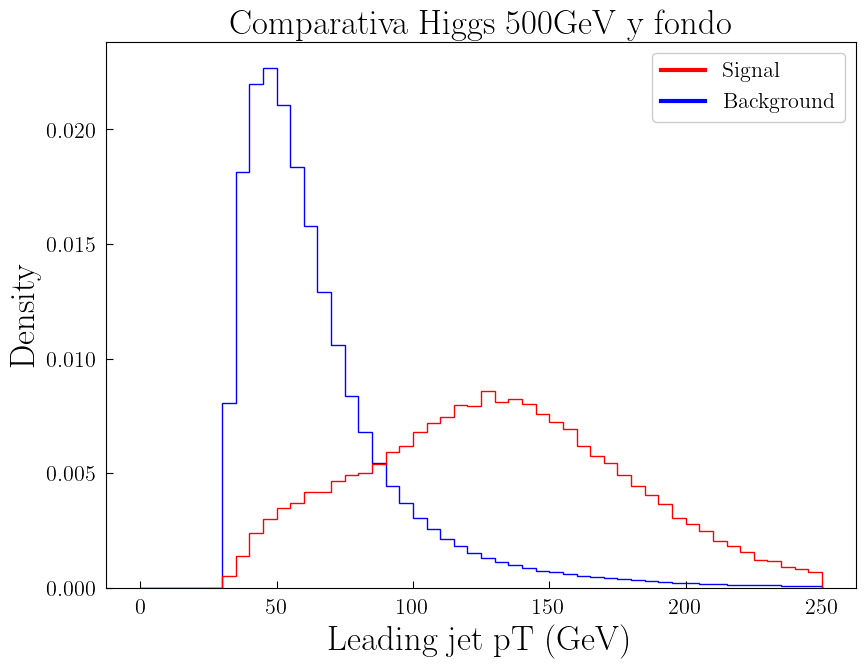

In [81]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.ptj1, ZJets.ptj1, 'Leading jet pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss350pt1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.ptj1, ZJets.ptj1, 'Leading jet pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss400pt1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.ptj1, ZJets.ptj1, 'Leading jet pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss500pt1_fondo.png")
plt.show()

Distribuciones cinemáticas - MOMENTO TRANSVERSO JET 2

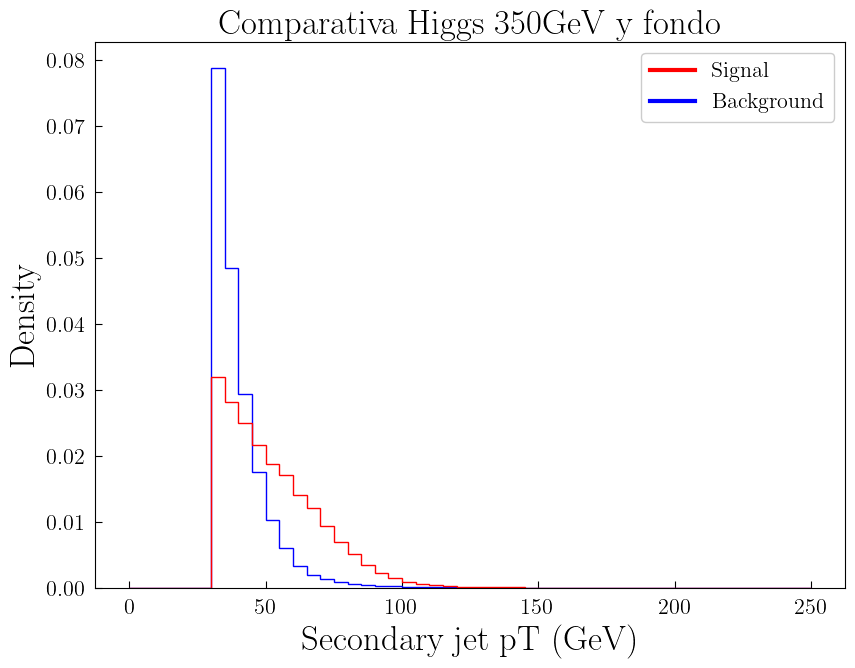

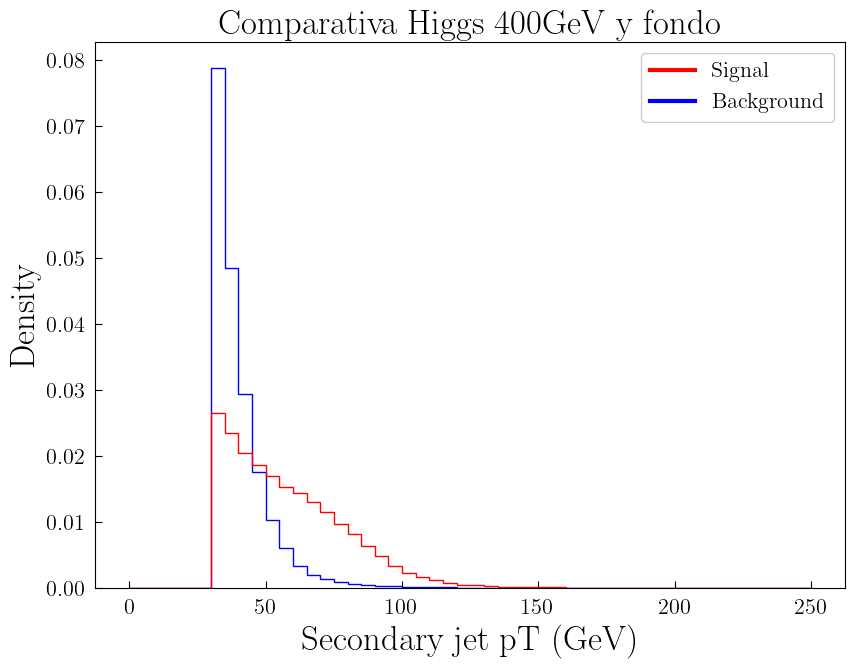

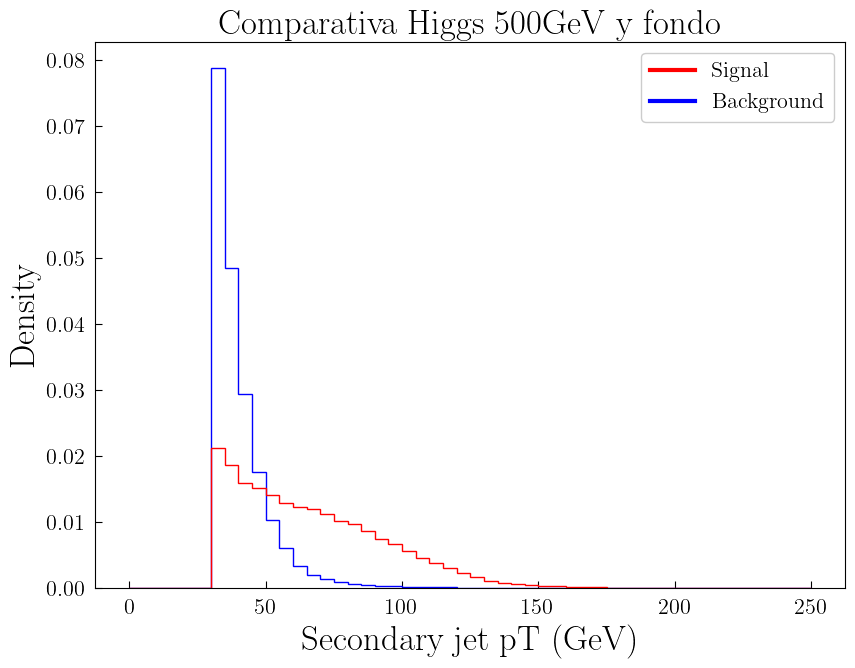

In [82]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.ptj2, ZJets.ptj2, 'Secondary jet pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss350pt2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.ptj2, ZJets.ptj2, 'Secondary jet pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss400pt2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.ptj2, ZJets.ptj2, 'Secondary jet pT (GeV)', [0,250], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss500pt2_fondo.png")
plt.show()

Distribuciones cinemáticas - PSEUDORAPIDITY JET 1

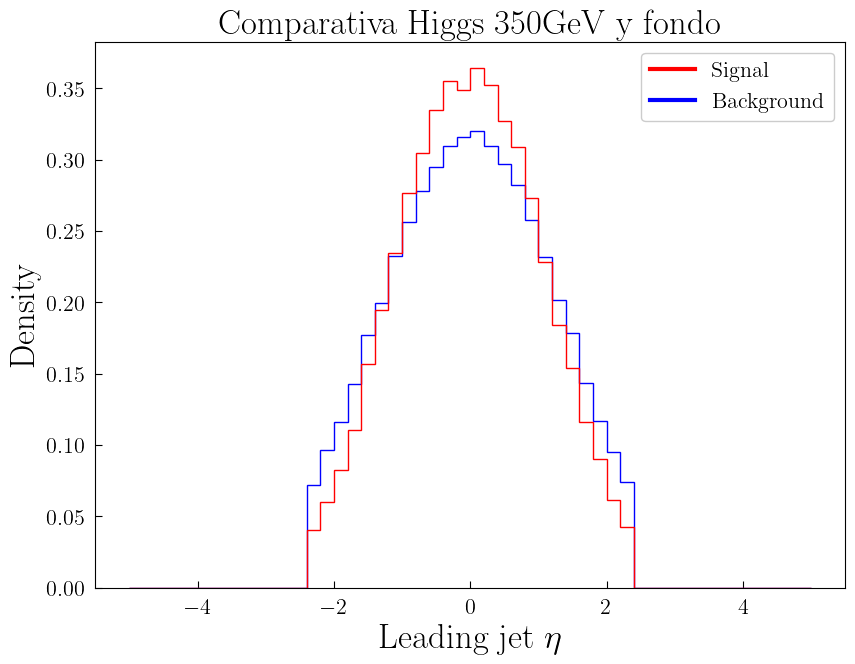

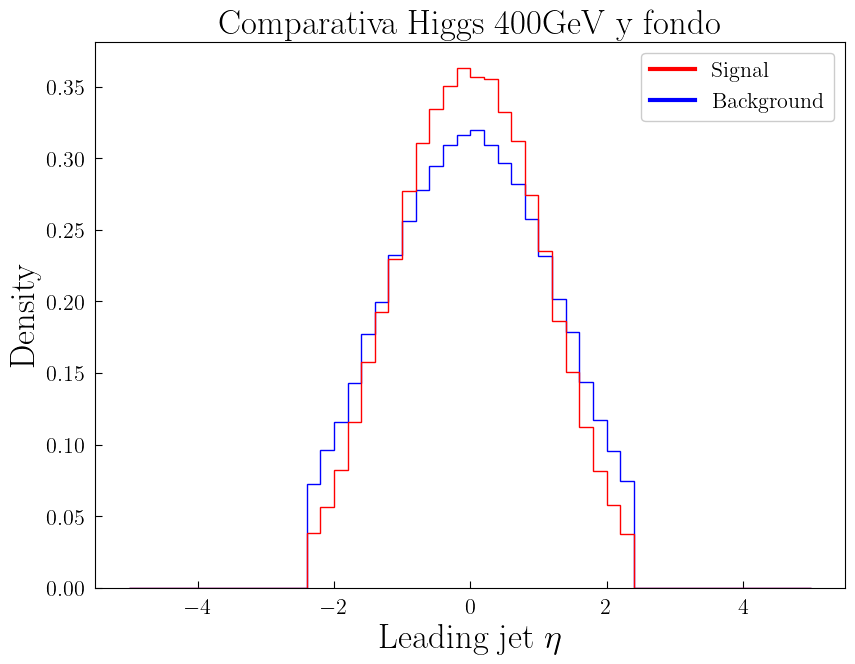

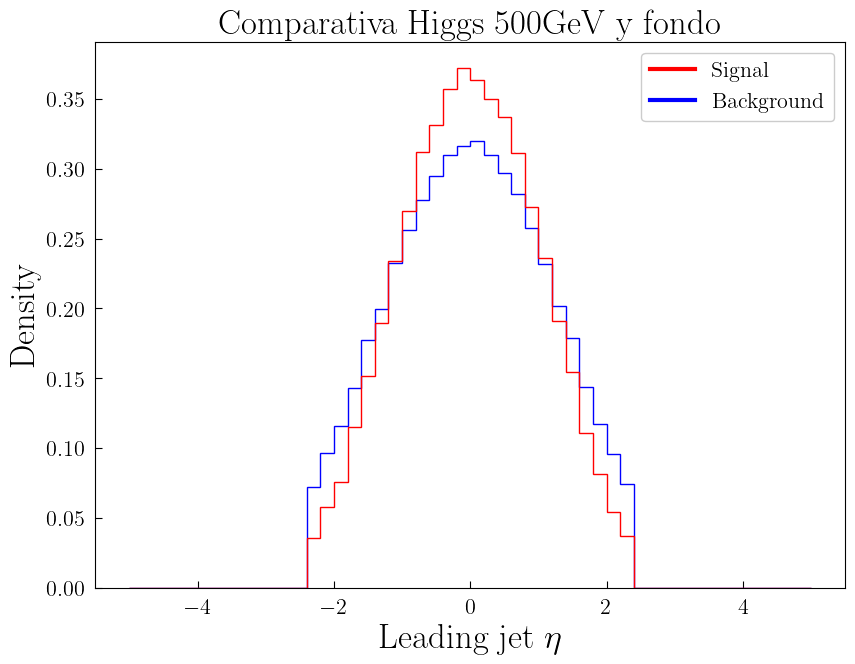

In [83]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.etaj1, ZJets.etaj1, 'Leading jet '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
#plt.xscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss350eta1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.etaj1, ZJets.etaj1, 'Leading jet '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
#plt.xscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss400eta1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.etaj1, ZJets.etaj1, 'Leading jet '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
#plt.xscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss500eta1_fondo.png")
plt.show()

Distribuciones cinemáticas - PSEUDORAPIDITY JET 2

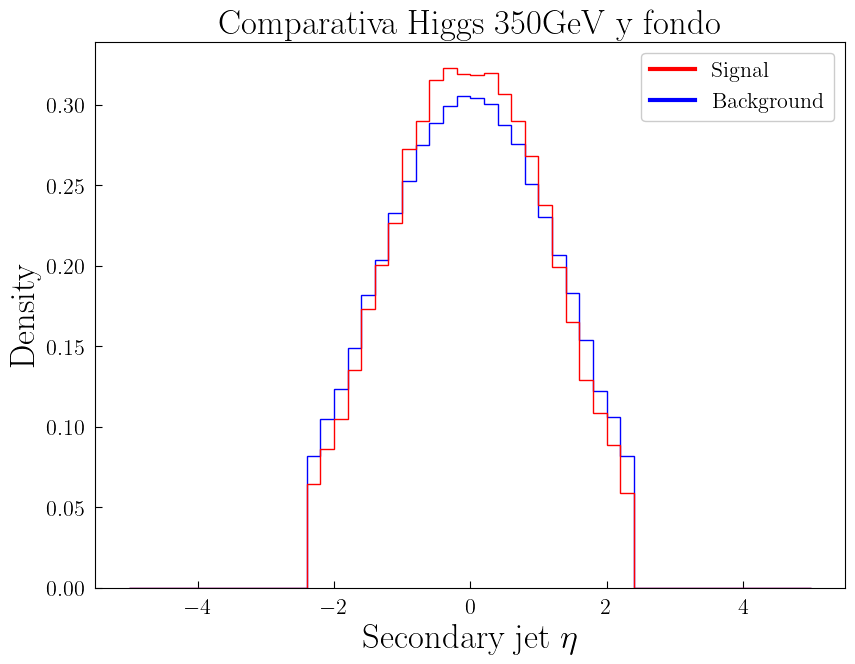

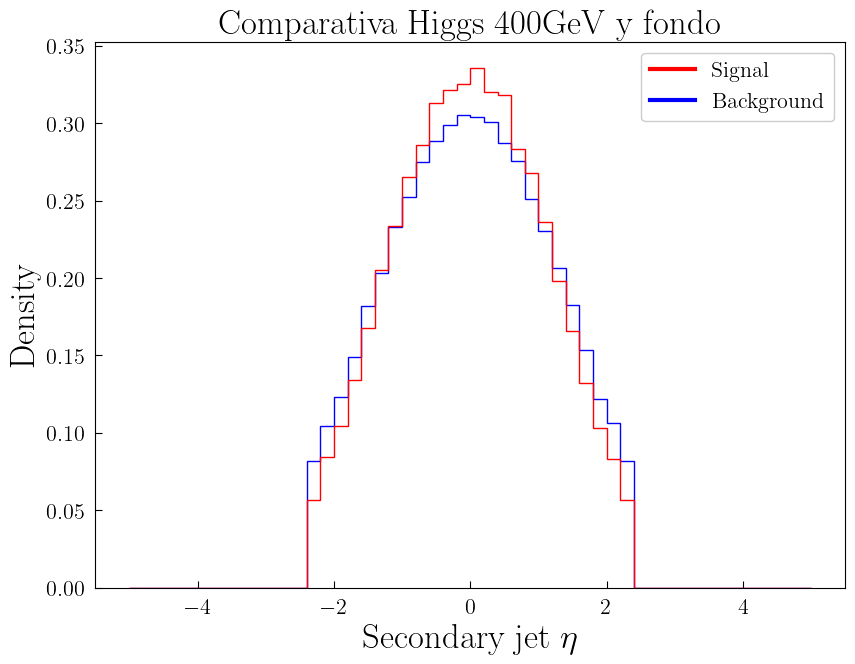

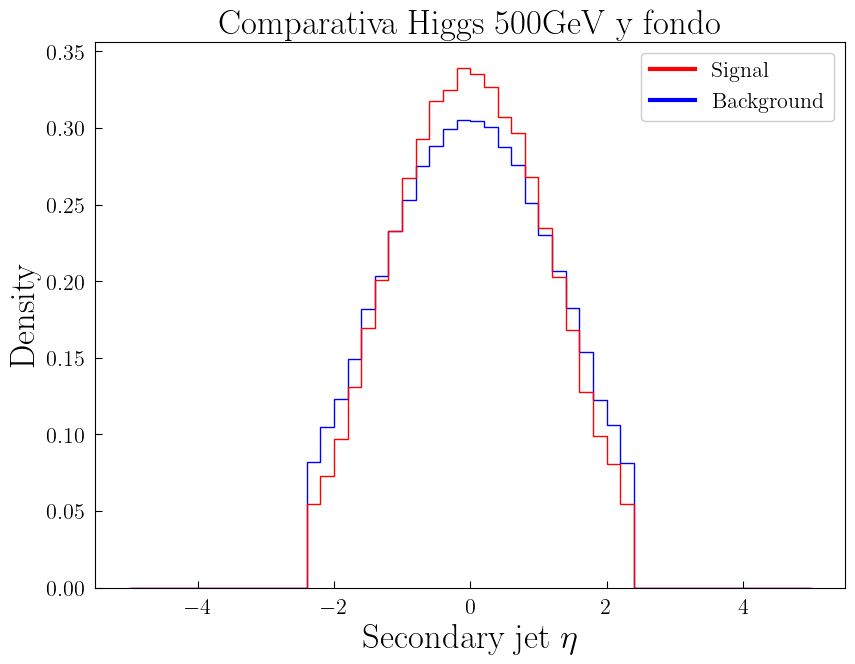

In [84]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.etaj2, ZJets.etaj2, 'Secondary jet '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss350eta2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.etaj2, ZJets.etaj2, 'Secondary jet '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss400eta2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.etaj2, ZJets.etaj2, 'Secondary jet '+r'$\eta$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss500eta2_fondo.png")
plt.show()

Distribuciones cinemáticas - ANGULO ACIMUTAL JET 1

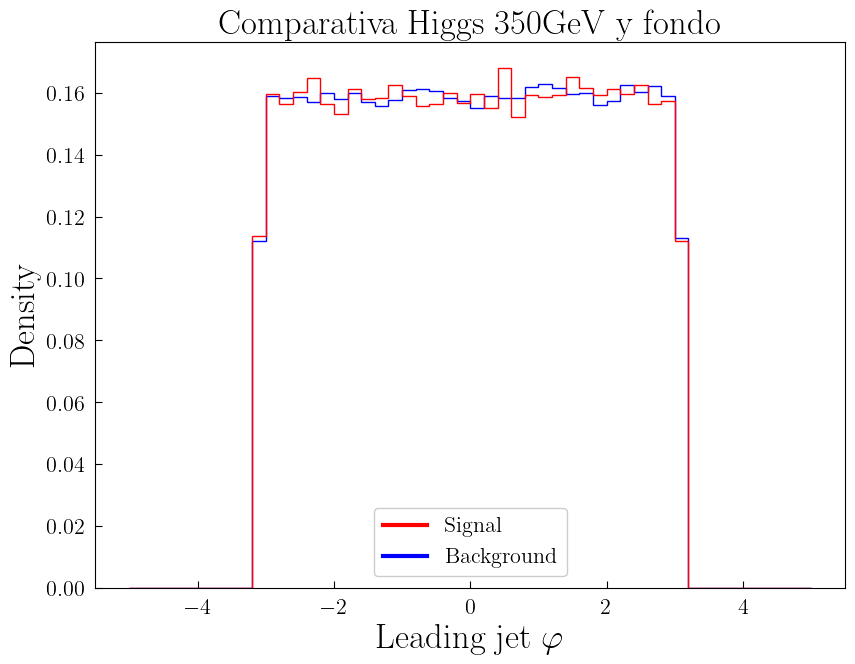

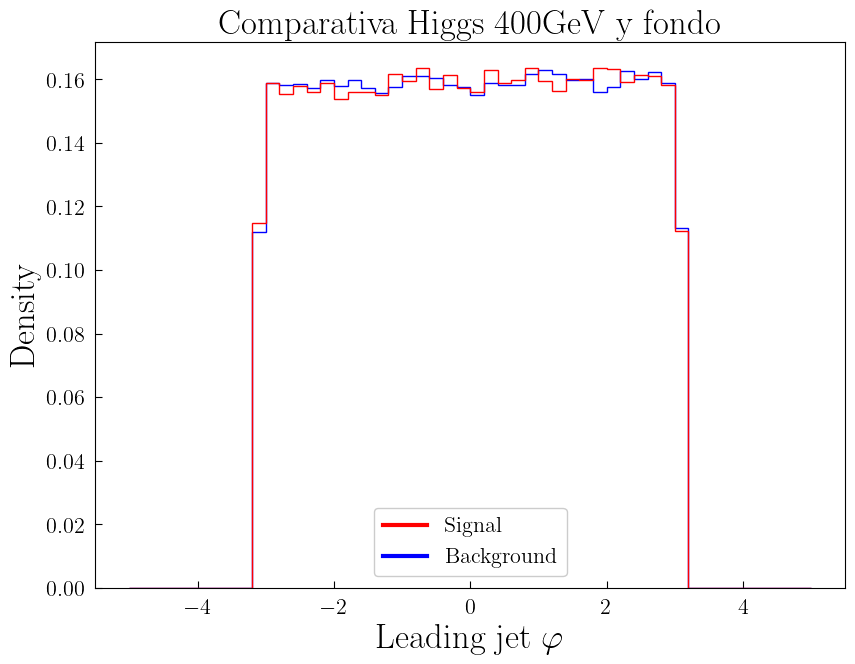

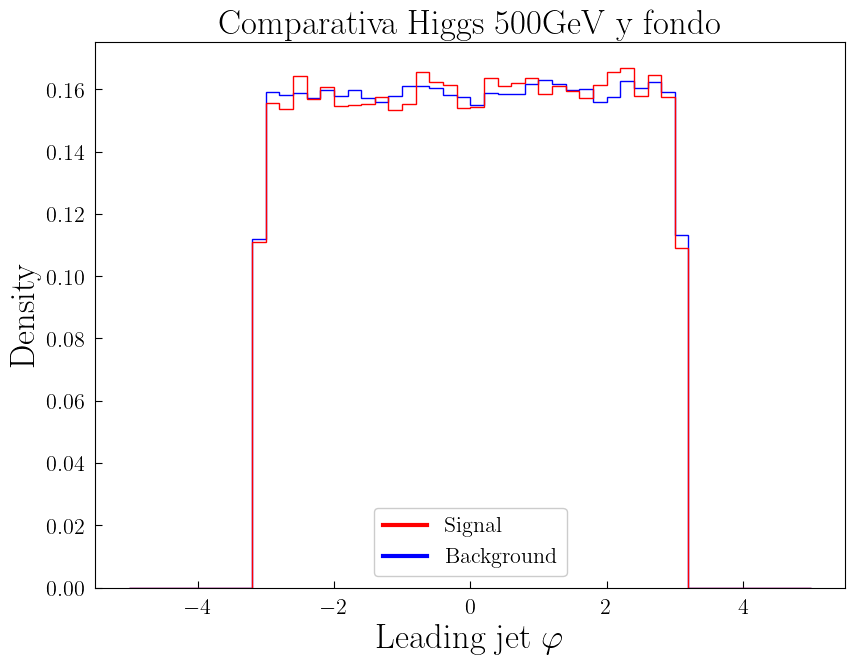

In [85]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.phij1, ZJets.phij1, 'Leading jet '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss350phi1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.phij1, ZJets.phij1, 'Leading jet '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss400phi1_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.phij1, ZJets.phij1, 'Leading jet '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss500phi1_fondo.png")
plt.show()

Distribuciones cinemáticas - ANGULO ACIMUTAL JET 2

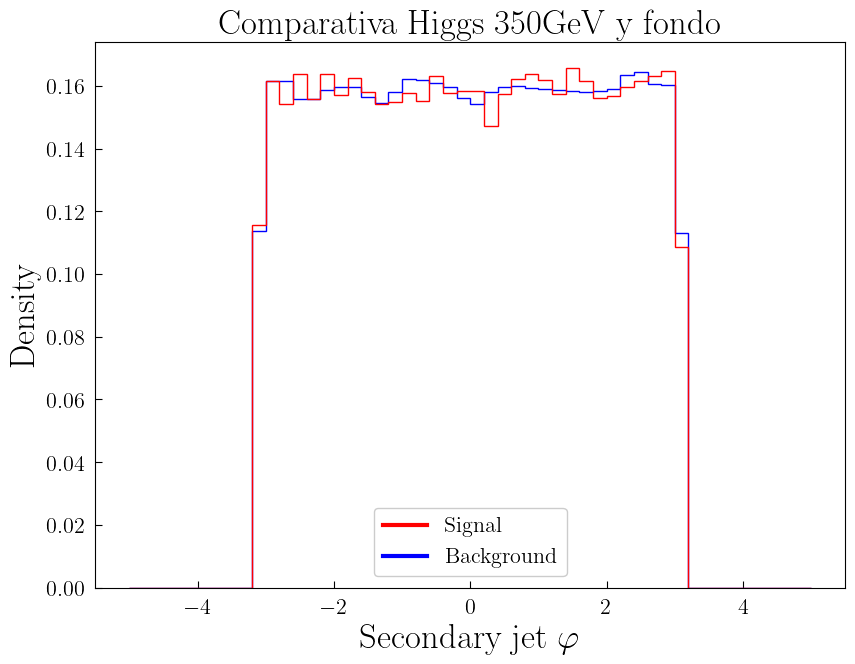

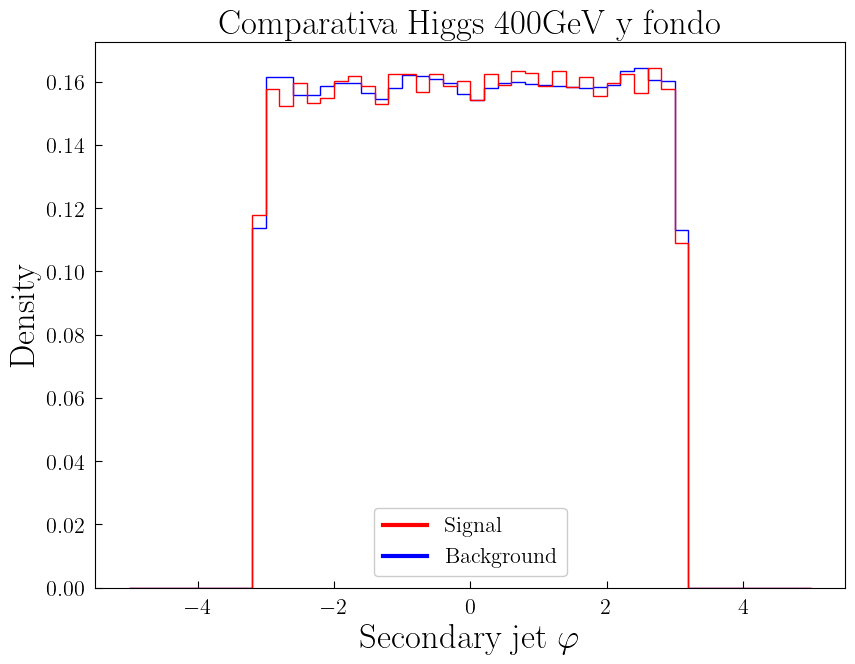

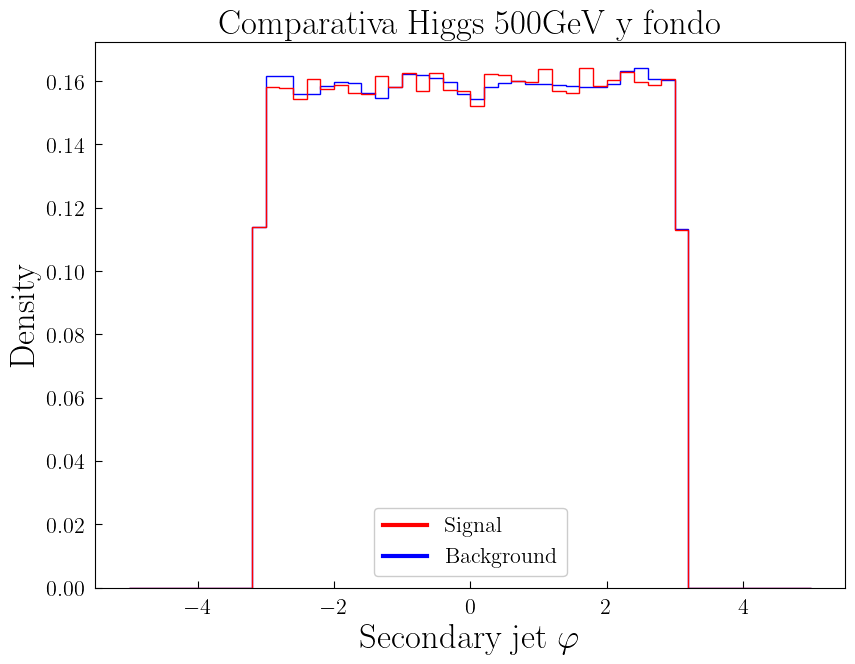

In [86]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.phij2, ZJets.phij2, 'Secondary jet '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss350phi2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.phij2, ZJets.phij2, 'Secondary jet '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss400phi2_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.phij2, ZJets.phij2, 'Secondary jet '+r'$\varphi$', [-5,5], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
#plt.yscale("log")
plt.savefig("Images/Comparativas_Jets/Comparativa_Higss500phi2_fondo.png")
plt.show()

## A - 2 : Reconstruccion de la masa invariante.

Construimos funciones paraa calcular el ángulo cenital THETA a partir de la pseudorapidity, con ella calcular el modulo del momento junto con momento transverso. Finalmente obtener M

$$ \eta = -\log{\left(\tan{\frac{\theta}{2}}\right)} \Longrightarrow \theta = 2 \cdot \arctan{(e^{-\eta})}$$
$$ p_T = \sqrt{p_x^2+p_y^2} \Longrightarrow |\vec{p}| = \frac{p_T}{\sin{\theta}\sqrt{\sin^2{\varphi}+\cos^2{\varphi}}}$$
$$ M = \sqrt{E^2-|\vec{p}|^2}$$

In [5]:

# A lo bruto

massll = lambda row: np.sqrt( (row.el1+row.el2)**2-( (row.ptl1*np.cos(row.phil1)+row.ptl2*np.cos(row.phil2))**2 + 
                                           (row.ptl1*np.sin(row.phil1)+row.ptl2*np.sin(row.phil2))**2 + 
                                           (row.ptl1*np.sinh(row.etal1)+row.ptl2*np.sinh(row.etal2))**2 ) )

massjj = lambda row: np.sqrt( (row.ej1+row.ej2)**2-( (row.ptj1*np.cos(row.phij1)+row.ptj2*np.cos(row.phij2))**2 + 
                                           (row.ptj1*np.sin(row.phij1)+row.ptj2*np.sin(row.phij2))**2 + 
                                           (row.ptj1*np.sinh(row.etaj1)+row.ptj2*np.sinh(row.etaj2))**2 ) )


# Total mass
masslljj = lambda row: np.sqrt( (row.el1+row.el2+row.ej1+row.ej2)**2-( (row.ptl1*np.cos(row.phil1)+row.ptl2*np.cos(row.phil2)+row.ptj1*np.cos(row.phij1)+row.ptj2*np.cos(row.phij2))**2 + 
                                           (row.ptl1*np.sin(row.phil1)+row.ptl2*np.sin(row.phil2)+row.ptj1*np.sin(row.phij1)+row.ptj2*np.sin(row.phij2))**2 + 
                                           (row.ptl1*np.sinh(row.etal1)+row.ptl2*np.sinh(row.etal2)+row.ptj1*np.sinh(row.etaj1)+row.ptj2*np.sinh(row.etaj2))**2 ) )



Añadimos como columnas las nuevas variables:

In [6]:

##########################  TOTAL MASS  ############################

# LEPTON MASS
col = Higgs350.apply(massll, axis=1)
Higgs350 = Higgs350.assign(massll=col.values)

col = Higgs400.apply(massll, axis=1)
Higgs400 = Higgs400.assign(massll=col.values)

col = Higgs500.apply(massll, axis=1)
Higgs500 = Higgs500.assign(massll=col.values)

col = ZJets.apply(massll, axis=1)
ZJets = ZJets.assign(massll=col.values)

col = Data.apply(massll, axis=1)
Data = Data.assign(massll=col.values)

# JET MASS
col = Higgs350.apply(massjj, axis=1)
Higgs350 = Higgs350.assign(massjj=col.values)

col = Higgs400.apply(massjj, axis=1)
Higgs400 = Higgs400.assign(massjj=col.values)

col = Higgs500.apply(massjj, axis=1)
Higgs500 = Higgs500.assign(massjj=col.values)

col = ZJets.apply(massjj, axis=1)
ZJets = ZJets.assign(massjj=col.values)

col = Data.apply(massjj, axis=1)
Data = Data.assign(massjj=col.values)

# TOTAL MASS
col = Higgs350.apply(masslljj, axis=1)
Higgs350 = Higgs350.assign(masslljj=col.values)

col = Higgs400.apply(masslljj, axis=1)
Higgs400 = Higgs400.assign(masslljj=col.values)

col = Higgs500.apply(masslljj, axis=1)
Higgs500 = Higgs500.assign(masslljj=col.values)

col = ZJets.apply(masslljj, axis=1)
ZJets = ZJets.assign(masslljj=col.values)

col = Data.apply(masslljj, axis=1)
Data = Data.assign(masslljj=col.values)






In [7]:
ZJets.to_csv("Datos/Procesados/ZJets.csv")
Higgs350.to_csv("Datos/Procesados/Higgs350.csv")
Higgs400.to_csv("Datos/Procesados/Higgs400.csv")
Higgs500.to_csv("Datos/Procesados/Higgs500.csv")
Data.to_csv("Datos/Procesados/Data.csv")


In [87]:
dir = "Datos/Procesados/"
ZJets    = pd.read_csv(dir+'ZJets.csv')
Higgs350 = pd.read_csv(dir+'Higgs350.csv')
Higgs400 = pd.read_csv(dir+'Higgs400.csv')
Higgs500 = pd.read_csv(dir+'Higgs500.csv')
Data     = pd.read_csv(dir+'Data.csv')

## Reconstruccion Leptones

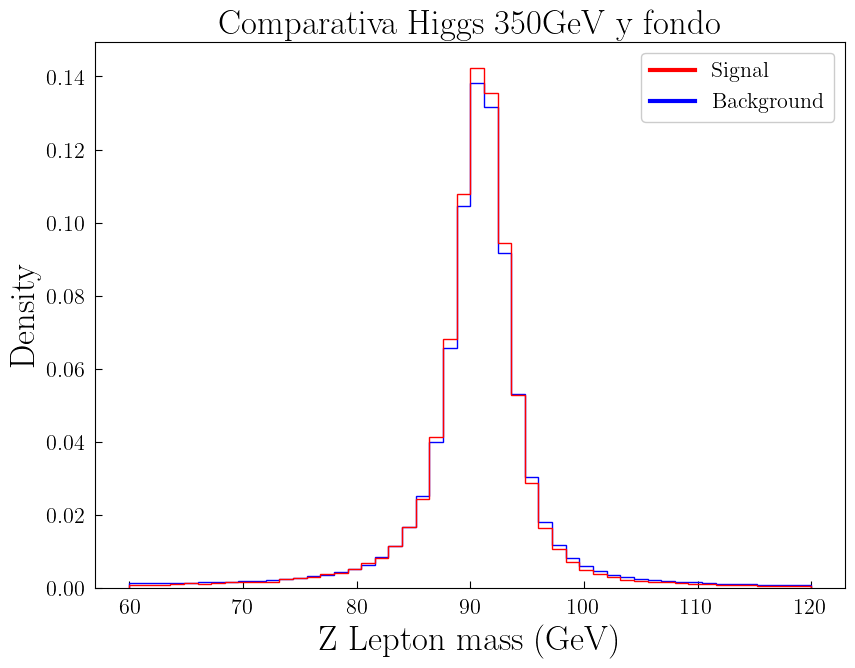

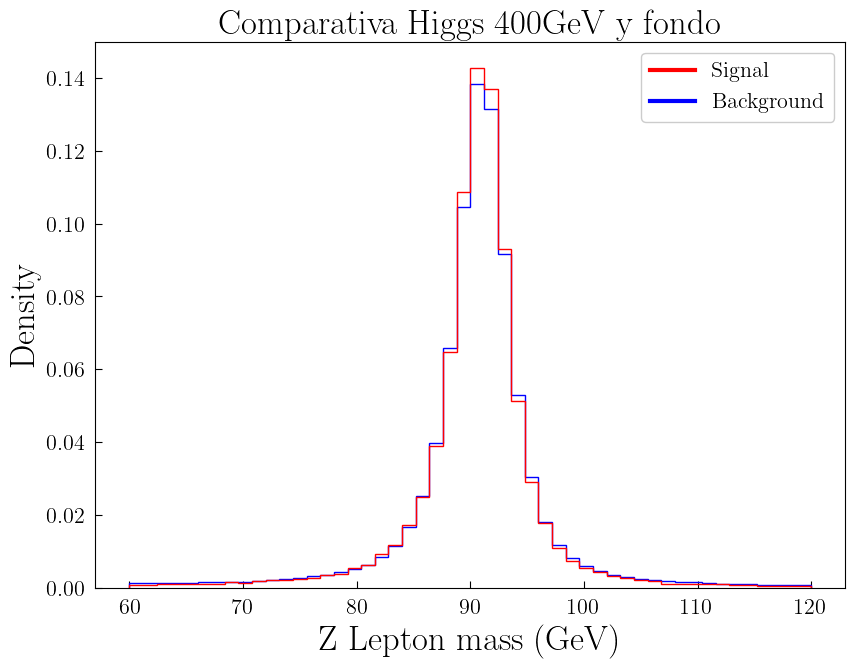

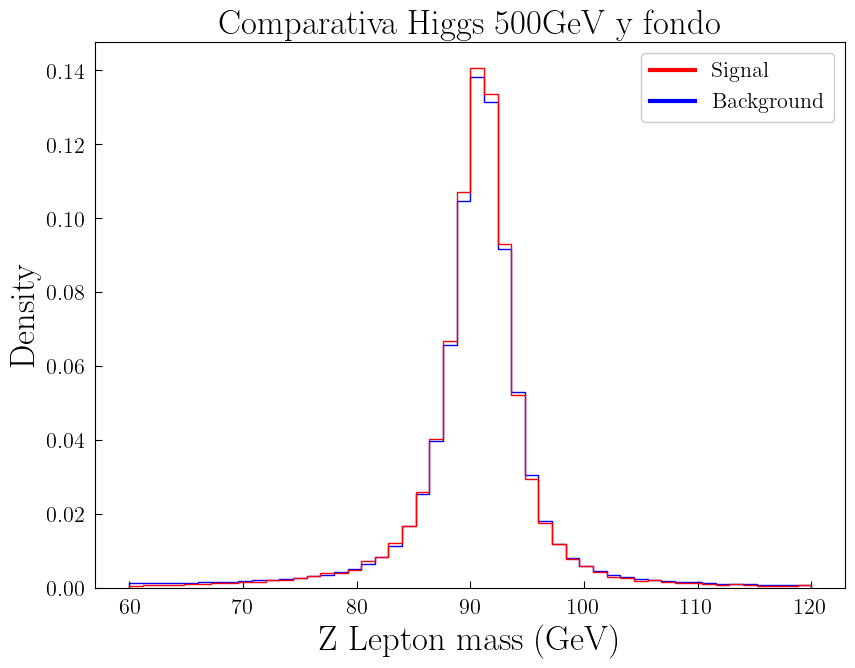

In [88]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.massll, ZJets.massll, 'Z Lepton mass (GeV)', [60,120], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
plt.savefig("Images/Reconstruccion_masas_Leptones/Comparativa_Higss350_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.massll, ZJets.massll, 'Z Lepton mass (GeV)', [60,120], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
plt.savefig("Images/Reconstruccion_masas_Leptones/Comparativa_Higss400_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.massll, ZJets.massll, 'Z Lepton mass (GeV)', [60,120], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
plt.savefig("Images/Reconstruccion_masas_Leptones/Comparativa_Higss500_fondo.png")
plt.show()

Ajustamos a Funciones Gaussianas y Breit-Wigner:


In [89]:
def gauss(x, mu, sigma, C):
    return C * np.exp(-0.5 * (x-mu)**2 / sigma**2) 

def BW(x, A, m0, width):
    return A / ((x-m0)**2 + (width/2)**2)

# function to get (x,y) values to fit from the histogram
def get_data(data, nb, r):
    return np.histogram(data, bins=nb, range=r)



In [90]:
param_L = {}

Parámetros del ajuste Higgs350 :  [9.03479185e+01 2.51893629e+00 1.15228068e+04]
Errores del ajuste de Higgs350 :  [5.87154220e-02 5.87154222e-02 2.32609254e+02]


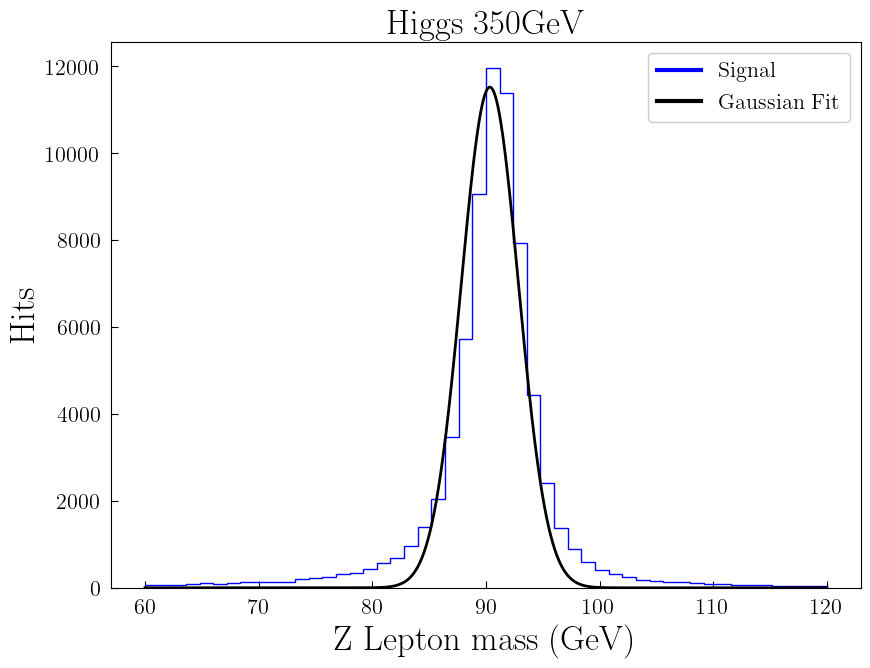

Parámetros del ajuste Higgs350 :  [7.02096566e+04 9.03747078e+01 4.69693774e+00]
Errores del ajuste de Higgs350 :  [2.18751350e+03 3.26120198e-02 9.25751398e-02]


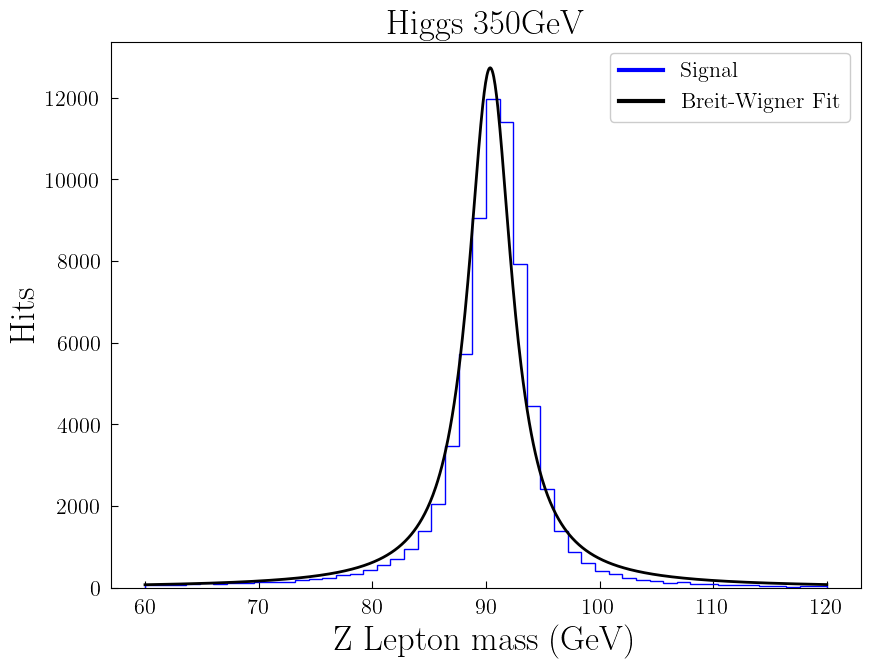

Parámetros del ajuste Higgs400 :  [9.03630678e+01 2.47626007e+00 1.28405009e+04]
Errores del ajuste de Higgs400 :  [6.33766289e-02 6.33766294e-02 2.84610986e+02]


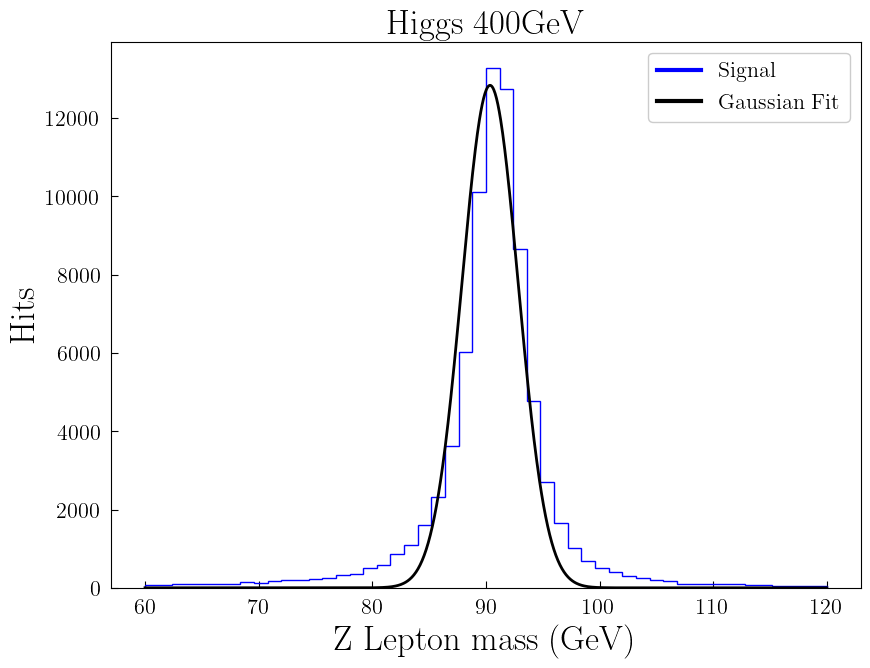

Parámetros del ajuste Higgs400 :  [7.60077560e+04 9.03837931e+01 4.62779938e+00]
Errores del ajuste de Higgs400 :  [2.05256914e+03 2.78329817e-02 7.90646277e-02]


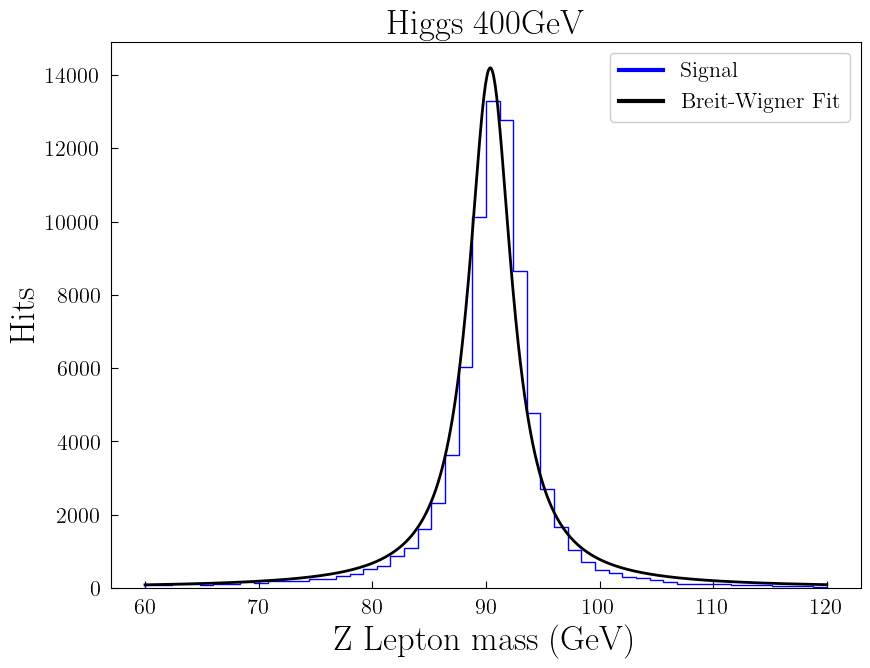

Parámetros del ajuste Higgs500 :  [9.03475366e+01 2.54709127e+00 1.39321033e+04]
Errores del ajuste de Higgs500 :  [6.34966843e-02 6.34966846e-02 3.00777479e+02]


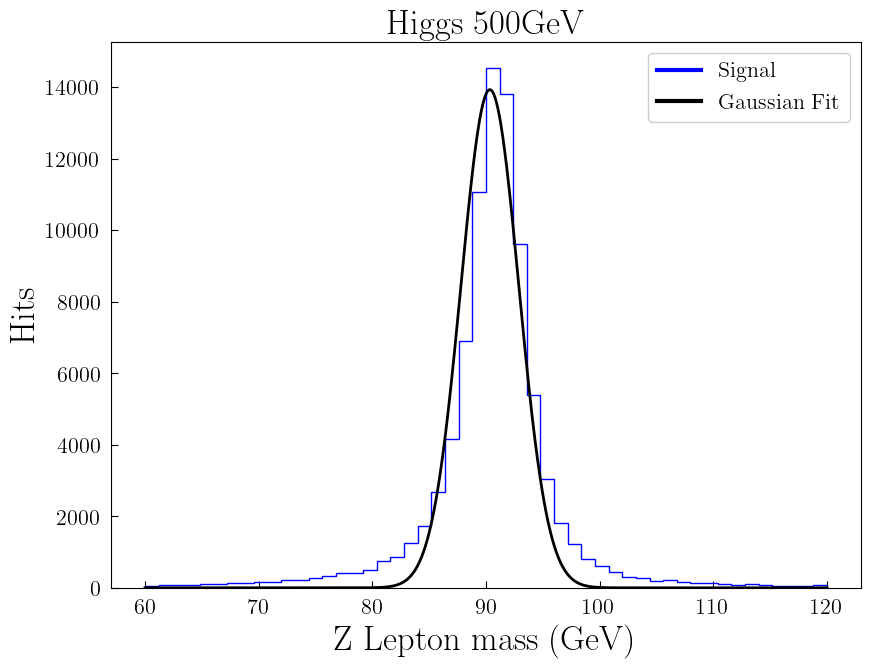

Parámetros del ajuste Higgs500 :  [8.68851101e+04 9.03712249e+01 4.74809416e+00]
Errores del ajuste de Higgs500 :  [2.37402819e+03 2.89197183e-02 8.20662474e-02]


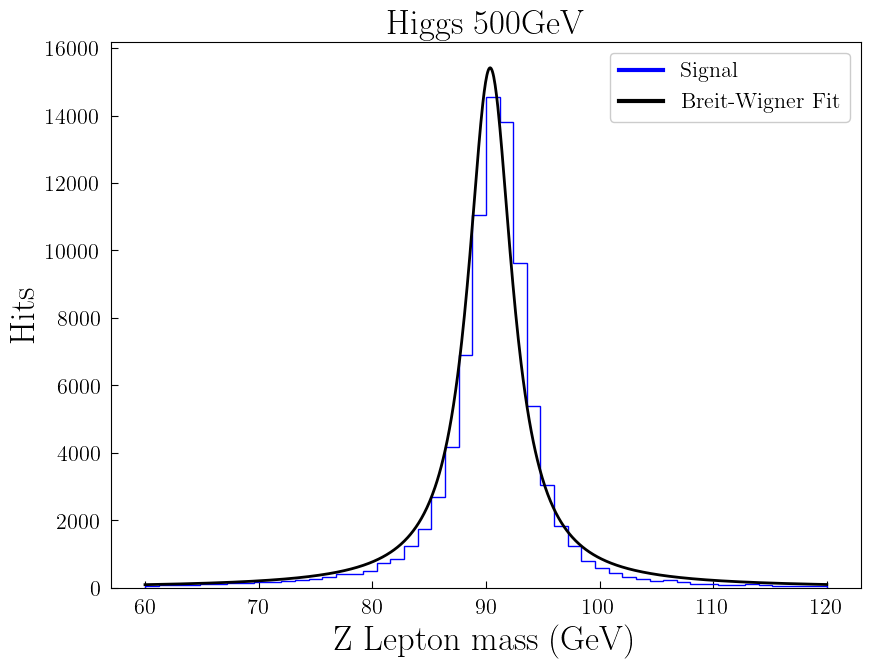

In [91]:
##  HIGGS 350

# gaussiana
y, x = get_data(Higgs350.massll, nb=50, r=[60,120])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=gauss, xdata=x, ydata=y, p0=[90, 10, 10000], bounds=(-np.inf, np.inf), maxfev=100000)
print("Parámetros del ajuste Higgs350 : ", params)
print("Errores del ajuste de Higgs350 : ",np.sqrt(np.diag(cov)))
param_L['H350_G']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs350.massll, 'Z Lepton mass (GeV)', [60,120])
x_aux = np.linspace(60,120,1000)
plt.plot(x_aux, gauss(x_aux,*params), label='Gaussian Fit', linewidth=2, color='black')  
plt.title(" Higgs 350GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Gaussian Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Leptones/Ajustes_Gauss/Higss350.png")
plt.show()



# breit wigner
y, x = get_data(Higgs350.massll, nb=50, r=[60,120])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=BW, xdata=x, ydata=y, p0=[0, 90, 1], bounds=(-np.inf, np.inf), maxfev=10000)
print("Parámetros del ajuste Higgs350 : ", params)
print("Errores del ajuste de Higgs350 : ",np.sqrt(np.diag(cov)))
param_L['H350_BW']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs350.massll, 'Z Lepton mass (GeV)', [60,120])
x_aux = np.linspace(60,120,1000)
plt.plot(x_aux, BW(x_aux,*params), label='Breit-Wigner Fit', linewidth=2, color='black')  
plt.title(" Higgs 350GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Breit-Wigner Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Leptones/Ajustes_Breit_Wigner/Higss350.png")
plt.show()






##  HIGGS 400

# gaussiana
y, x = get_data(Higgs400.massll, nb=50, r=[60,120])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=gauss, xdata=x, ydata=y, p0=[90, 10, 10000], bounds=(-np.inf, np.inf), maxfev=10000)
print("Parámetros del ajuste Higgs400 : ", params)
print("Errores del ajuste de Higgs400 : ",np.sqrt(np.diag(cov)))
param_L['H400_G']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs400.massll, 'Z Lepton mass (GeV)', [60,120])
x_aux = np.linspace(60,120,1000)
plt.plot(x_aux, gauss(x_aux,*params), label='Gaussian Fit', linewidth=2, color='black')  
plt.title(" Higgs 400GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Gaussian Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Leptones/Ajustes_Gauss/Higss400.png")
plt.show()




# breit wigner
y, x = get_data(Higgs400.massll, nb=50, r=[60,120])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=BW, xdata=x, ydata=y, p0=[0, 90, 1], bounds=(-np.inf, np.inf), maxfev=10000)
print("Parámetros del ajuste Higgs400 : ", params)
print("Errores del ajuste de Higgs400 : ",np.sqrt(np.diag(cov)))
param_L['H400_BW']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs400.massll, 'Z Lepton mass (GeV)', [60,120])
x_aux = np.linspace(60,120,1000)
plt.plot(x_aux, BW(x_aux,*params), label='Breit-Wigner Fit', linewidth=2, color='black')  
plt.title(" Higgs 400GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Breit-Wigner Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Leptones/Ajustes_Breit_Wigner/Higss400.png")
plt.show()






##  HIGGS 500

# gaussiana
y, x = get_data(Higgs500.massll, nb=50, r=[60,120])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=gauss, xdata=x, ydata=y, p0=[90, 10, 10000], bounds=(-np.inf, np.inf), maxfev=10000)
print("Parámetros del ajuste Higgs500 : ", params)
print("Errores del ajuste de Higgs500 : ",np.sqrt(np.diag(cov)))
param_L['H500_G']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs500.massll, 'Z Lepton mass (GeV)', [60,120])
x_aux = np.linspace(60,120,1000)
plt.plot(x_aux, gauss(x_aux,*params), label='Gaussian Fit', linewidth=2, color='black')  
plt.title(" Higgs 500GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Gaussian Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Leptones/Ajustes_Gauss/Higss500.png")
plt.show()



# breit wigner
y, x = get_data(Higgs500.massll, nb=50, r=[60,120])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=BW, xdata=x, ydata=y, p0=[0, 90, 1], bounds=(-np.inf, np.inf), maxfev=10000)
print("Parámetros del ajuste Higgs500 : ", params)
print("Errores del ajuste de Higgs500 : ",np.sqrt(np.diag(cov)))
param_L['H500_BW']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs500.massll, 'Z Lepton mass (GeV)', [60,120])
x_aux = np.linspace(60,120,1000)
plt.plot(x_aux, BW(x_aux,*params), label='Breit-Wigner Fit', linewidth=2, color='black')  
plt.title(" Higgs 500GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Breit-Wigner Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Leptones/Ajustes_Breit_Wigner/Higss500.png")
plt.show()


## Reconstruccion Jets

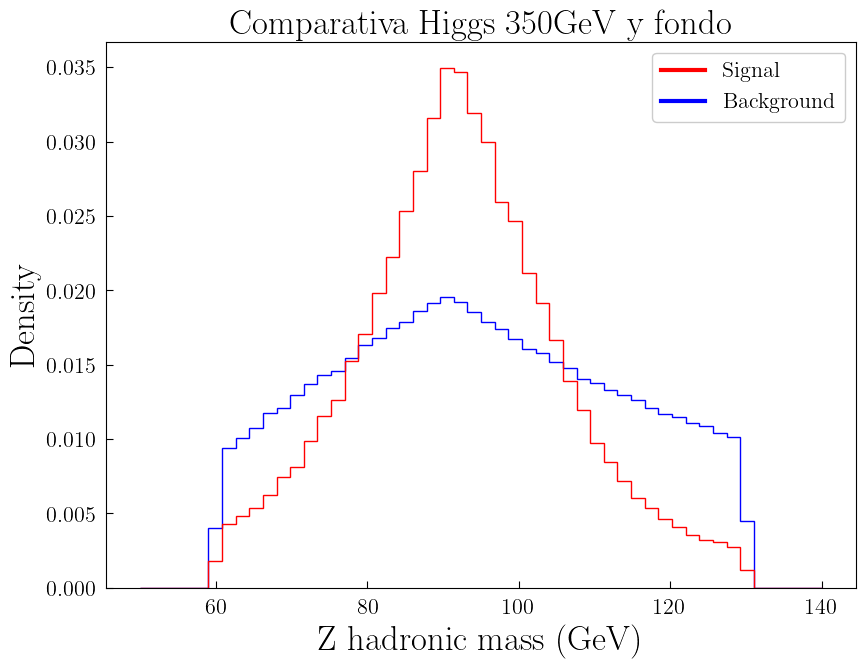

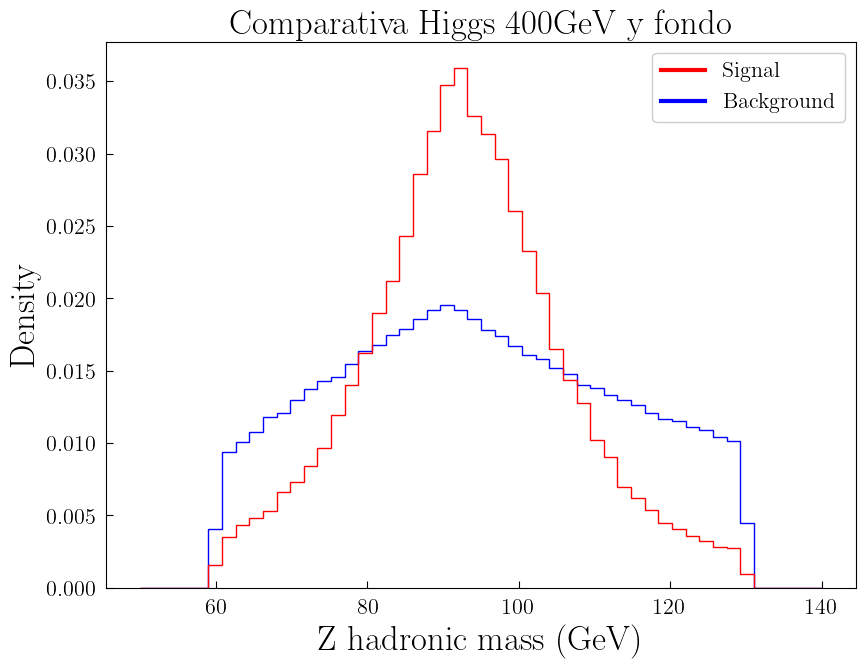

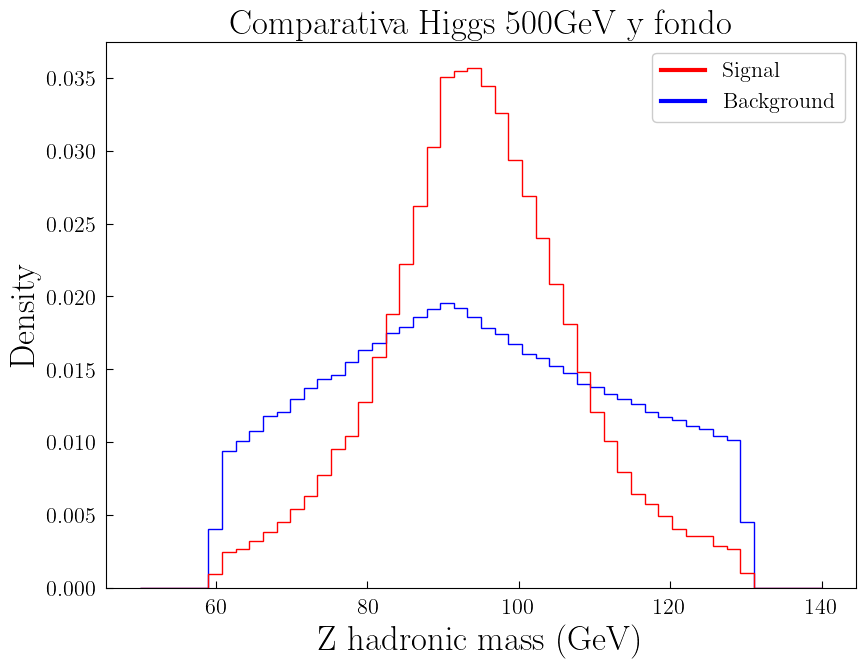

In [92]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.massjj, ZJets.massjj, 'Z hadronic mass (GeV)', [50,140], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
plt.savefig("Images/Reconstruccion_masas_Jets/Comparativa_Higss350_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.massjj, ZJets.massjj, 'Z hadronic mass (GeV)', [50,140], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
plt.savefig("Images/Reconstruccion_masas_Jets/Comparativa_Higss400_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.massjj, ZJets.massjj, 'Z hadronic mass (GeV)', [50,140], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
plt.savefig("Images/Reconstruccion_masas_Jets/Comparativa_Higss500_fondo.png")
plt.show()

Ajustamos a Funciones Gaussianas y Breit-Wigner:


In [93]:
def gauss(x, mu, sigma, C):
    return C * np.exp(-0.5 * (x-mu)**2 / sigma**2) 

def BW(x, A, m0, width):
    return A / ((x-m0)**2 + (width/2)**2)

# function to get (x,y) values to fit from the histogram
def get_data(data, nb, r):
    return np.histogram(data, bins=nb, range=r)



In [94]:
param_J = {}

Parámetros del ajuste Higgs350 :  [  91.13481226   12.60714345 3070.91516333]
Errores del ajuste de Higgs350 :  [ 0.27980966  0.28203717 59.08087061]


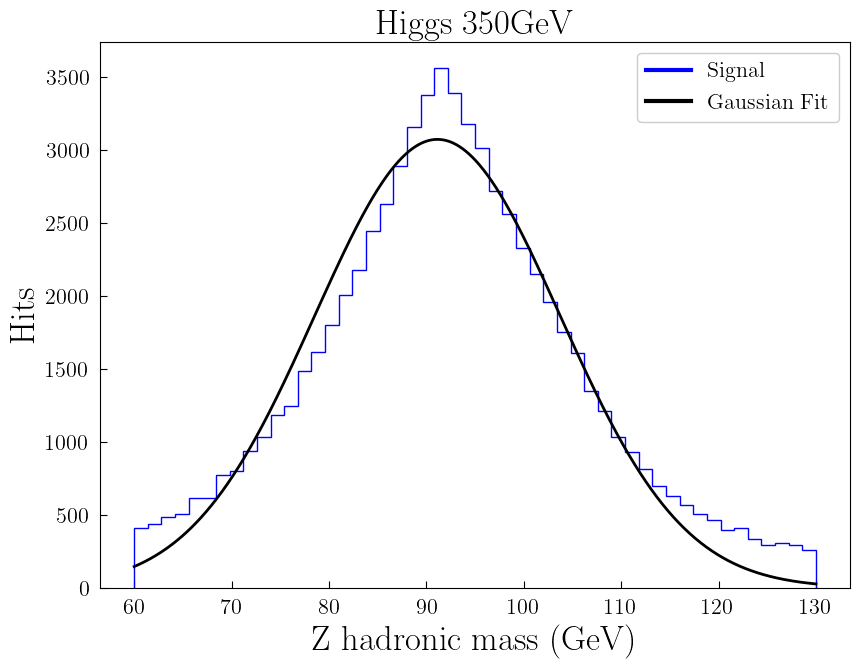

Parámetros del ajuste Higgs350 :  [4.84475446e+05 9.11141337e+01 2.38964565e+01]
Errores del ajuste de Higgs350 :  [8.95150574e+03 9.24140602e-02 2.77106202e-01]


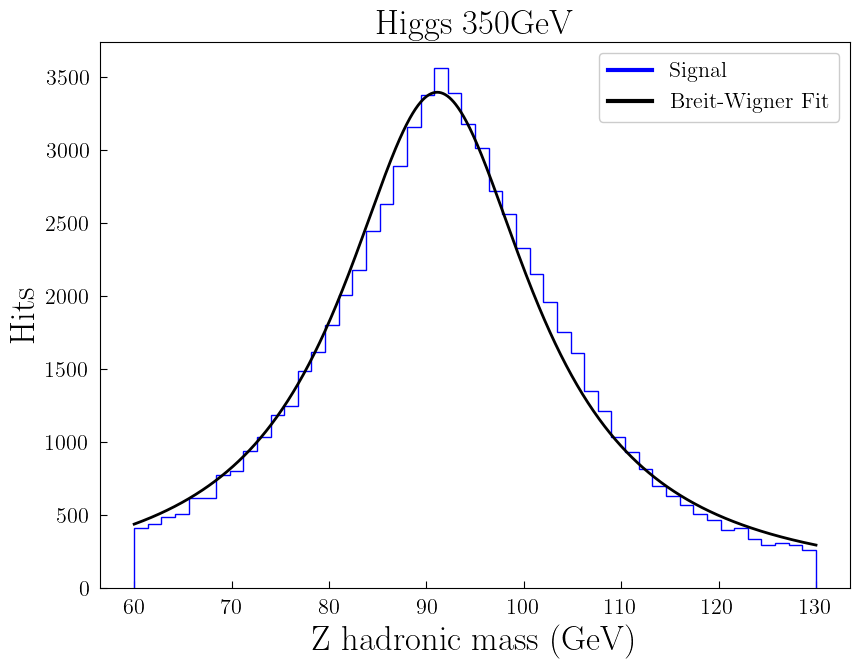

Parámetros del ajuste Higgs400 :  [  91.87141135   12.07089122 3529.89123479]
Errores del ajuste de Higgs400 :  [ 0.25543316  0.25647472 64.72756997]


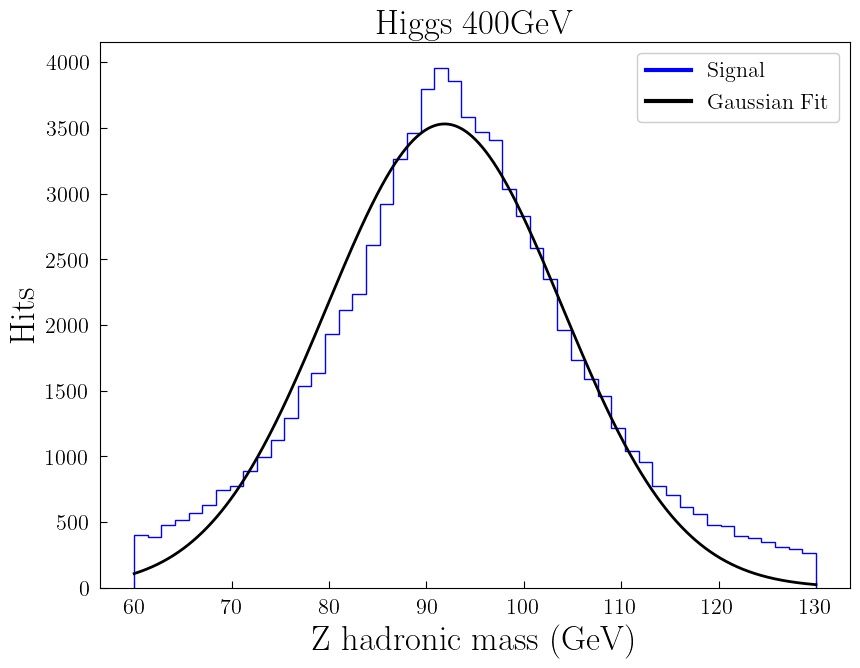

Parámetros del ajuste Higgs400 :  [5.11673199e+05 9.18288569e+01 2.29379081e+01]
Errores del ajuste de Higgs400 :  [1.02248331e+04 9.66343143e-02 2.87944456e-01]


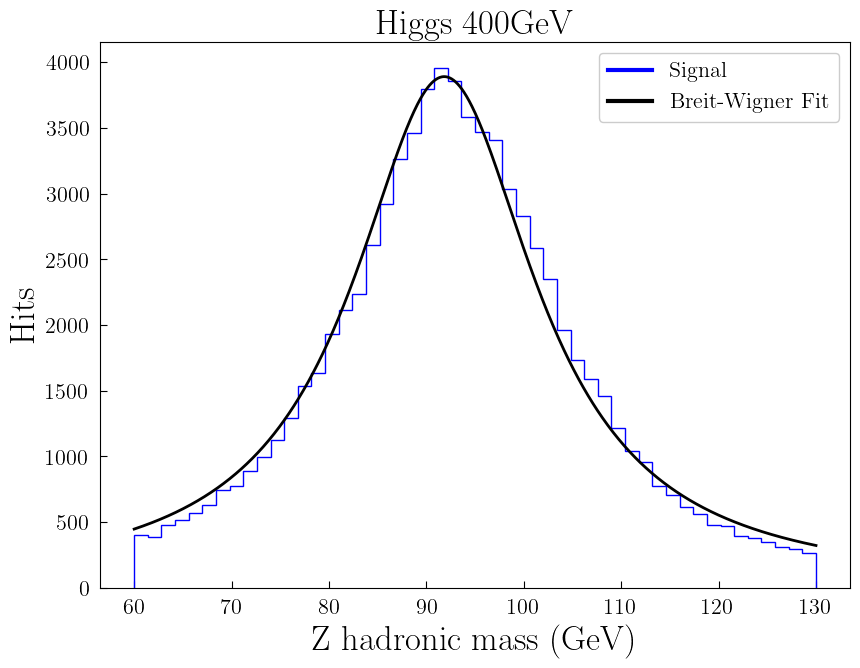

Parámetros del ajuste Higgs500 :  [  93.72978241  -11.36515564 4151.76767636]
Errores del ajuste de Higgs500 :  [ 0.21361453  0.21387255 67.59459175]


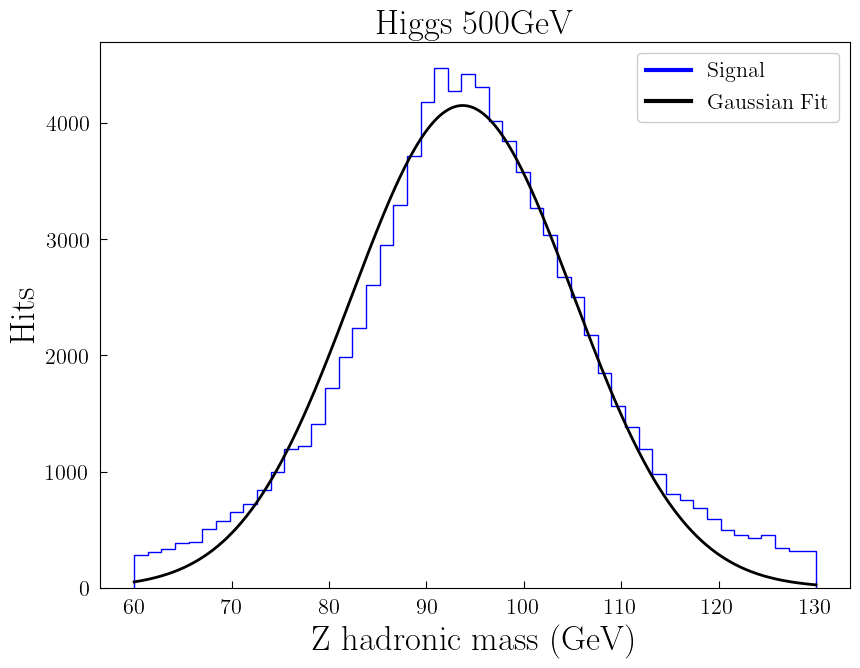

Parámetros del ajuste Higgs500 :  [5.35540007e+05 9.35828488e+01 2.16987322e+01]
Errores del ajuste de Higgs500 :  [1.60229638e+04 1.38067887e-01 4.08275180e-01]


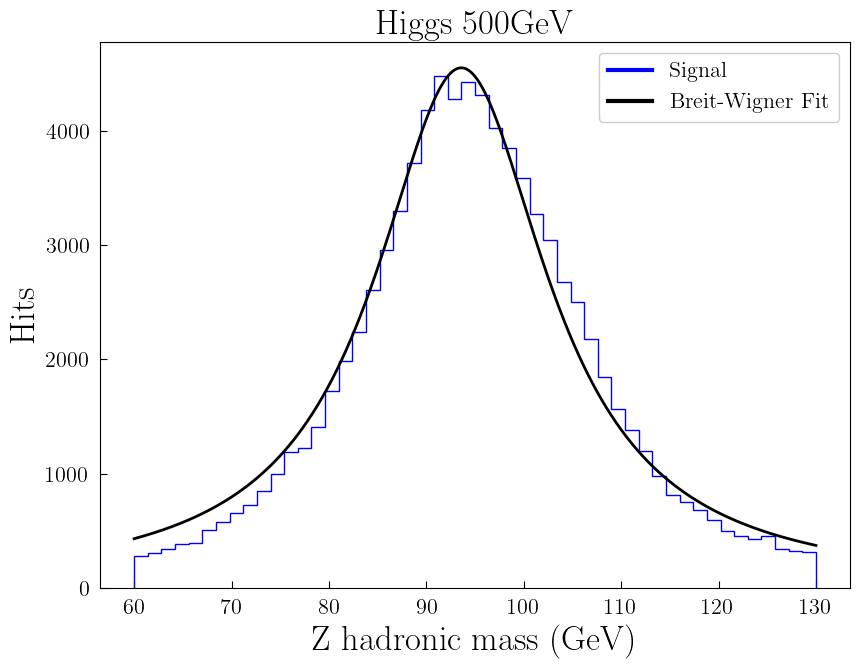

In [95]:
##  HIGGS 350

# gaussiana
y, x = get_data(Higgs350.massjj, nb=50, r=[60,130])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=gauss, xdata=x, ydata=y, p0=[30, 10, 5000], bounds=(-np.inf, np.inf), maxfev=1000000)
print("Parámetros del ajuste Higgs350 : ", params)
print("Errores del ajuste de Higgs350 : ",np.sqrt(np.diag(cov)))
param_J['H350_G']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs350.massjj, 'Z hadronic mass (GeV)', [60,130])
x_aux = np.linspace(60,130,1000)
plt.plot(x_aux, gauss(x_aux,*params), label='Gaussian Fit', linewidth=2, color='black')  
plt.title(" Higgs 350GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Gaussian Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Jets/Ajustes_Gauss/Higss350.png")
plt.show()



# breit wigner
y, x = get_data(Higgs350.massjj, nb=50, r=[60,130])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=BW, xdata=x, ydata=y, p0=[0, 90, 1], bounds=(-np.inf, np.inf), maxfev=100000)
print("Parámetros del ajuste Higgs350 : ", params)
print("Errores del ajuste de Higgs350 : ",np.sqrt(np.diag(cov)))
param_J['H350_BW']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs350.massjj, 'Z hadronic mass (GeV)', [60,130])
x_aux = np.linspace(60,130,1000)
plt.plot(x_aux, BW(x_aux,*params), label='Breit-Wigner Fit', linewidth=2, color='black')  
plt.title(" Higgs 350GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Breit-Wigner Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Jets/Ajustes_Breit_Wigner/Higss350.png")
plt.show()






##  HIGGS 400

# gaussiana
y, x = get_data(Higgs400.massjj, nb=50, r=[60,130])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=gauss, xdata=x, ydata=y, p0=[30, 10, 5000], bounds=(-np.inf, np.inf), maxfev=100000)
print("Parámetros del ajuste Higgs400 : ", params)
print("Errores del ajuste de Higgs400 : ",np.sqrt(np.diag(cov)))
param_J['H400_G']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs400.massjj, 'Z hadronic mass (GeV)', [60,130])
x_aux = np.linspace(60,130,1000)
plt.plot(x_aux, gauss(x_aux,*params), label='Gaussian Fit', linewidth=2, color='black')  
plt.title(" Higgs 400GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Gaussian Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Jets/Ajustes_Gauss/Higss400.png")
plt.show()



# breit wigner
y, x = get_data(Higgs400.massjj, nb=50, r=[60,130])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=BW, xdata=x, ydata=y, p0=[0, 90, 1], bounds=(-np.inf, np.inf), maxfev=100000)
print("Parámetros del ajuste Higgs400 : ", params)
print("Errores del ajuste de Higgs400 : ",np.sqrt(np.diag(cov)))
param_J['H400_BW']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs400.massjj, 'Z hadronic mass (GeV)', [60,130])
x_aux = np.linspace(60,130,1000)
plt.plot(x_aux, BW(x_aux,*params), label='Breit-Wigner Fit', linewidth=2, color='black')  
plt.title(" Higgs 400GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Breit-Wigner Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Jets/Ajustes_Breit_Wigner/Higss400.png")
plt.show()





##  HIGGS 500

# gaussiana
y, x = get_data(Higgs500.massjj, nb=50, r=[60,130])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=gauss, xdata=x, ydata=y, p0=[30, 20, 5000], bounds=(-np.inf, np.inf), maxfev=100000)
print("Parámetros del ajuste Higgs500 : ", params)
print("Errores del ajuste de Higgs500 : ",np.sqrt(np.diag(cov)))
param_J['H500_G']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs500.massjj, 'Z hadronic mass (GeV)', [60,130])
x_aux = np.linspace(60,130,1000)
plt.plot(x_aux, gauss(x_aux,*params), label='Gaussian Fit', linewidth=2, color='black')  
plt.title(" Higgs 500GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Gaussian Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Jets/Ajustes_Gauss/Higss500.png")
plt.show()



# breit wigner
y, x = get_data(Higgs500.massjj, nb=50, r=[60,130])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=BW, xdata=x, ydata=y, p0=[0, 90, 1], bounds=(-np.inf, np.inf), maxfev=100000)
print("Parámetros del ajuste Higgs500 : ", params)
print("Errores del ajuste de Higgs500 : ",np.sqrt(np.diag(cov)))
param_J['H500_BW']=[[params],[np.sqrt(np.diag(cov))]]

figure_features()
plt.figure(figsize=(10,7))
plot_hist(Higgs500.massjj, 'Z hadronic mass (GeV)', [60,130])
x_aux = np.linspace(60,130,1000)
plt.plot(x_aux, BW(x_aux,*params), label='Breit-Wigner Fit', linewidth=2, color='black')  
plt.title(" Higgs 500GeV ",fontsize=25)

handle1 = matplotlib.lines.Line2D([], [], c='b')
handle2 = matplotlib.lines.Line2D([], [], c='k')
leg = plt.legend(handles=[handle1,handle2],labels=['Signal','Breit-Wigner Fit'])
# change the line width for the legend
for line in leg.get_lines():
    line.set_linewidth(3.0)

plt.savefig("Images/Reconstruccion_masas_Jets/Ajustes_Breit_Wigner/Higss500.png")
plt.show()


## Angular likelihood discriminant

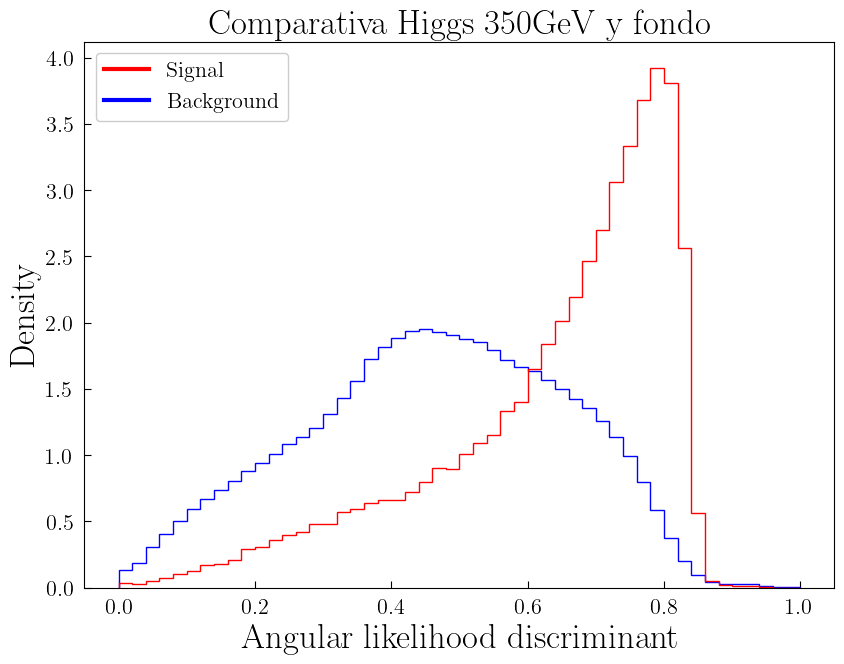

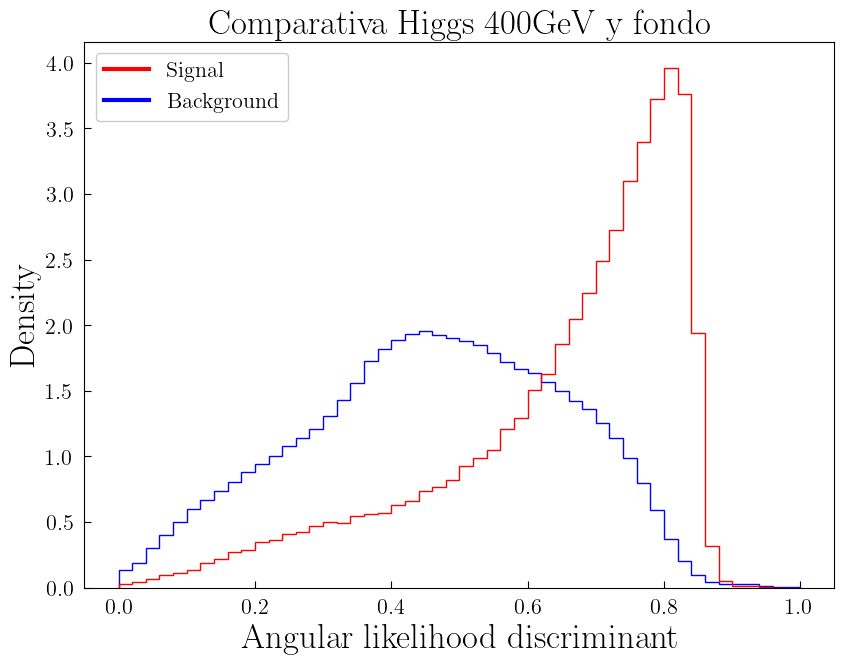

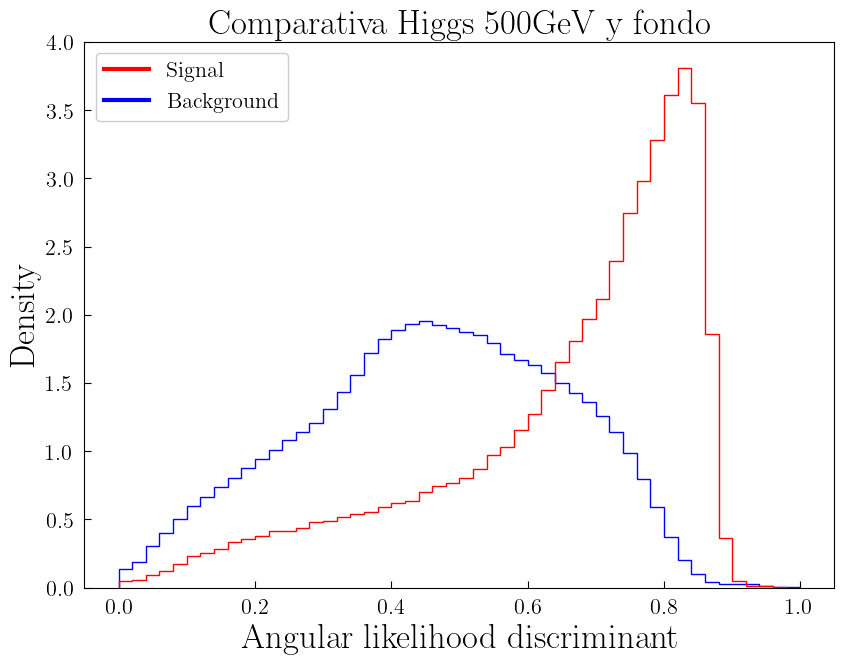

In [96]:
figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs350.ld, ZJets.ld, 'Angular likelihood discriminant', [0,1], d=True, l=0)
plt.title("Comparativa Higgs 350GeV y fondo",fontsize=25)
plt.savefig("Images/Angular_likelihood_discriminant/Comparativa_Higss350_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs400.ld, ZJets.ld, 'Angular likelihood discriminant', [0,1], d=True, l=0)
plt.title("Comparativa Higgs 400GeV y fondo",fontsize=25)
plt.savefig("Images/Angular_likelihood_discriminant/Comparativa_Higss400_fondo.png")
plt.show()

figure_features()
plt.figure(figsize=(10,7))
compare_dist(Higgs500.ld, ZJets.ld, 'Angular likelihood discriminant', [0,1], d=True, l=0)
plt.title("Comparativa Higgs 500GeV y fondo",fontsize=25)
plt.savefig("Images/Angular_likelihood_discriminant/Comparativa_Higss500_fondo.png")
plt.show()

## Vemos cortes segun Ang.Likelihood Discr. para mH = 400 GeV

In [9]:

cut1 = lambda row: (row.ptl1>68)  
cut2 = lambda row: (row.ld>0.7) & (row.ptl1>68)
cut3 = lambda row: (row.massjj>70) & (row.massjj<110) & (row.ld>0.7) & (row.ptl1>68)
cut4 = lambda row: (row.ptj1>64) & (row.massjj>70) & (row.massjj<110) & (row.ld>0.7) & (row.ptl1>68)
cut5 = lambda row: (row.etal1<1.5) & (row.etal1>-1.5) & (row.ptj1>64) & (row.massjj>70) & (row.massjj<110) & (row.ld>0.7) & (row.ptl1>68)

H350Sel1 = Higgs350.loc[Higgs350.apply(cut1, axis=1), 'ptl1']
BackSel1 = ZJets.loc[ZJets.apply(cut1, axis=1), 'ptl1']

H350Sel2 = Higgs350.loc[Higgs350.apply(cut2, axis=1), 'ld']
BackSel2 = ZJets.loc[ZJets.apply(cut2, axis=1), 'ld']

H350Sel3 = Higgs350.loc[Higgs350.apply(cut3, axis=1), 'massjj']
BackSel3 = ZJets.loc[ZJets.apply(cut3, axis=1), 'massjj']

H350Sel4 = Higgs350.loc[Higgs350.apply(cut4, axis=1), 'ptj1']
BackSel4 = ZJets.loc[ZJets.apply(cut4, axis=1), 'ptj1']

H350Sel5 = Higgs350.loc[Higgs350.apply(cut5, axis=1), 'etal1']
BackSel5 = ZJets.loc[ZJets.apply(cut5, axis=1), 'etal1']



print("Total numero de eventos de señal : ",len(Higgs350.ptl1))
print("Total numero de eventos de fondo : ",len(ZJets.ld))

print("")

print("Numero eventos de señal con cut1 pTl1 : ", len(H350Sel1))
print("Numero eventos de señal con cut2 ld : ", len(H350Sel2))
print("Numero eventos de señal con cut3 Mjj : ", len(H350Sel3))
print("Numero eventos de señal con cut4 pTj1 : ", len(H350Sel4))
print("Numero eventos de señal con cut5 etal1 : ", len(H350Sel5))

print("")

print("Numero eventos de fondo con cut1 ptl1 : ", len(BackSel1))
print("Numero eventos de fondo con cut2 ld : ", len(BackSel2))
print("Numero eventos de fondo con cut3 Mjj : ", len(BackSel3))
print("Numero eventos de fondo con cut4 pTj1 : ", len(BackSel4))
print("Numero eventos de fondo con cut5 etal1 : ", len(BackSel5))


Total numero de eventos de señal :  71317
Total numero de eventos de fondo :  406260

Numero eventos de señal con cut1 pTl1 :  62619
Numero eventos de señal con cut2 ld :  32279
Numero eventos de señal con cut3 Mjj :  27473
Numero eventos de señal con cut4 pTj1 :  25332
Numero eventos de señal con cut5 etal1 :  23017

Numero eventos de fondo con cut1 ptl1 :  158200
Numero eventos de fondo con cut2 ld :  28357
Numero eventos de fondo con cut3 Mjj :  17495
Numero eventos de fondo con cut4 pTj1 :  13339
Numero eventos de fondo con cut5 etal1 :  11294


## B - Estudio de una muestra de datos

Representamos la reconstrucción de la masa Mlljj

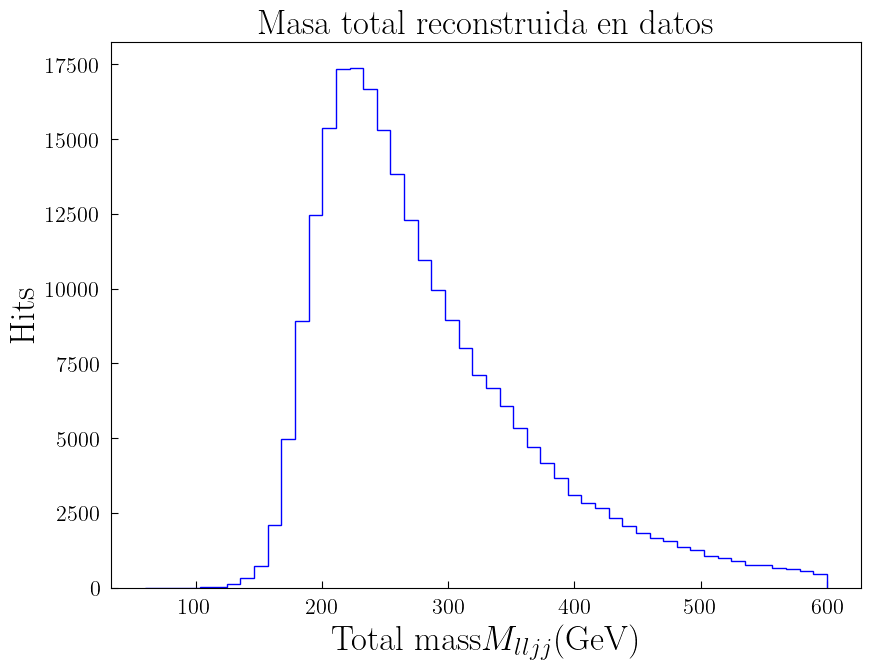

In [97]:
figure_features()
plt.figure(figsize=(10,7))
plot_hist(Data.masslljj, 'Total mass'+r'$M_{lljj}$'+'(GeV)', [60,600])
plt.title("Masa total reconstruida en datos",fontsize=25)
plt.savefig("Images/Real_data/M_lljj.png")
plt.show()


## Comparamos los datos con la prediccion de la simulacion de fondo

In [98]:
# luminosities in data and in simulations
lumData = 19.7
lumZj   = 33.4
lumH350 = 405
lumH400 = 541
lumH500 = 1271

Comparacion con HIGGS 350

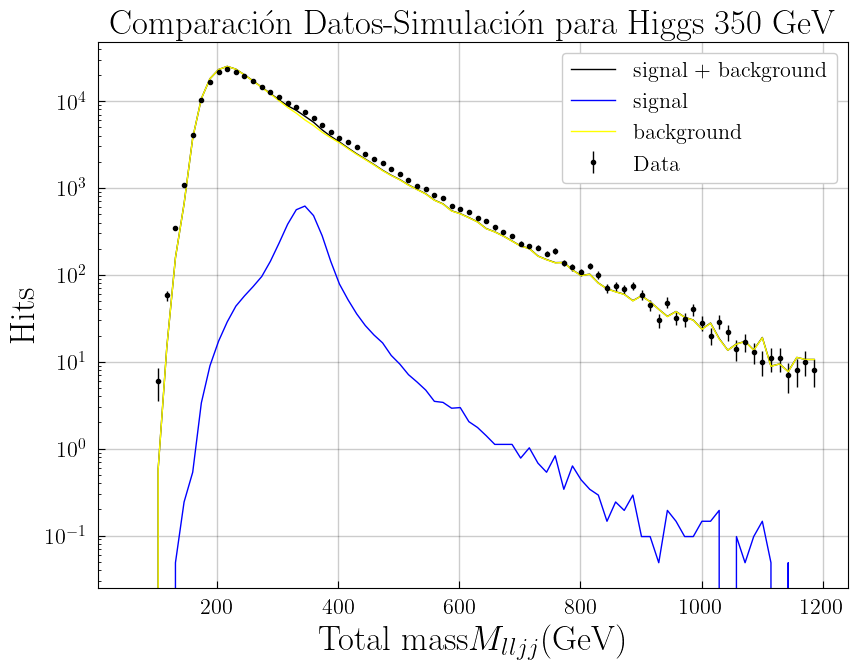

In [99]:
figure_features()
plt.figure(figsize=(10,7))
compare_data_sim(Data.masslljj,ZJets.masslljj,Higgs350.masslljj,lumH350,'Total mass'+r'$M_{lljj}$'+'(GeV)',r=[60,1200],l=0)
plt.title("Comparación Datos-Simulación para Higgs 350 GeV",fontsize=25)
plt.yscale("log")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.savefig("Images/Real_data/Comparison_simulations_data_H350.png")
plt.show()


Comparacion con HIGGS 400

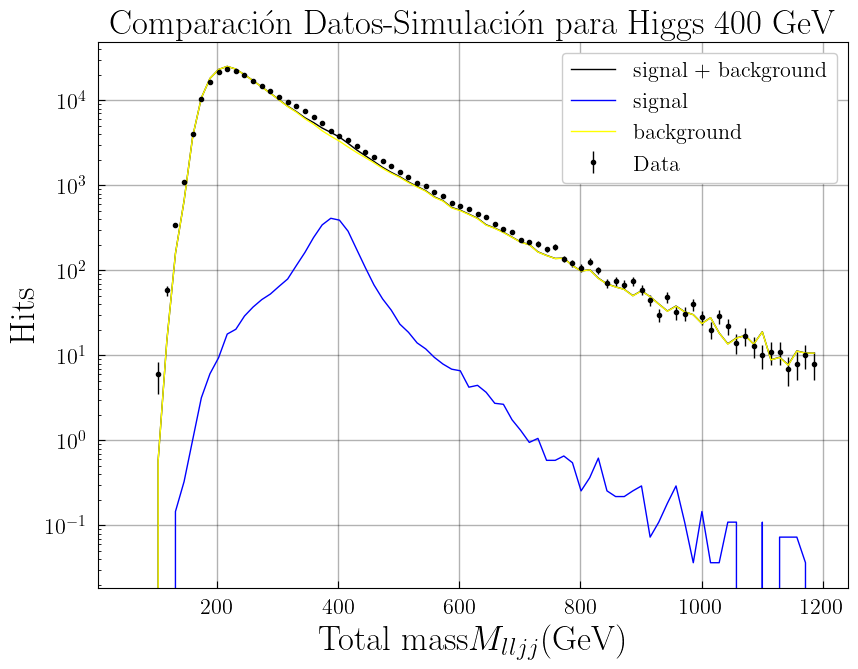

In [100]:
figure_features()
plt.figure(figsize=(10,7))
compare_data_sim(Data.masslljj,ZJets.masslljj,Higgs400.masslljj,lumH400,'Total mass'+r'$M_{lljj}$'+'(GeV)',r=[60,1200],l=0)
plt.title("Comparación Datos-Simulación para Higgs 400 GeV",fontsize=25)
plt.yscale("log")
plt.grid(linewidth=1, color='black', alpha=0.3)
plt.savefig("Images/Real_data/Comparison_simulations_data_H400.png")
plt.show()


Comparacion con HIGGS 500

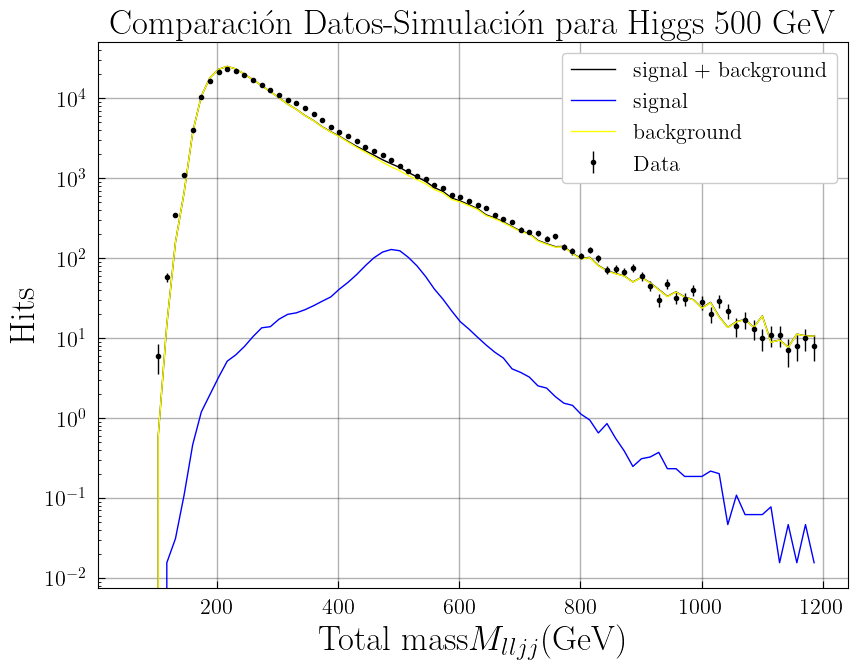

In [101]:
figure_features()
plt.figure(figsize=(10,7))
compare_data_sim(Data.masslljj,ZJets.masslljj,Higgs500.masslljj,lumH500,'Total mass'+r'$M_{lljj}$'+'(GeV)',r=[60,1200],l=0)
plt.title("Comparación Datos-Simulación para Higgs 500 GeV",fontsize=25)
plt.yscale("log")
plt.grid(linewidth=1, color='black', alpha=0.3)
plt.savefig("Images/Real_data/Comparison_simulations_data_H500.png")
plt.show()


Representamos ahora Mlljj con los cortes de selección de A)

Estudiamos los cortes optimos:

## Plot Cutting Significance

Discriminante en MOMENTO TRANSVEROS DE LEPTON PRIMARIO

ptl1 óptima :  68.0


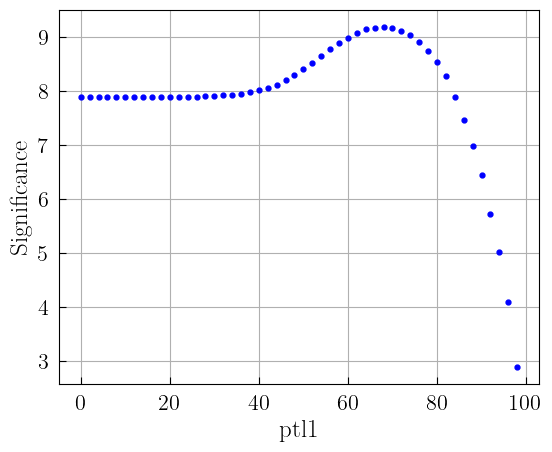

In [53]:
plotCutSignificance(Higgs350, ZJets, 'ptl1', r=[0,100], ns=50, mode=1, Hmass=350, Hwidth=50, lumH=lumH350)

Discriminante en ANGULAR LIKELIHOOD

ld óptima :  0.6


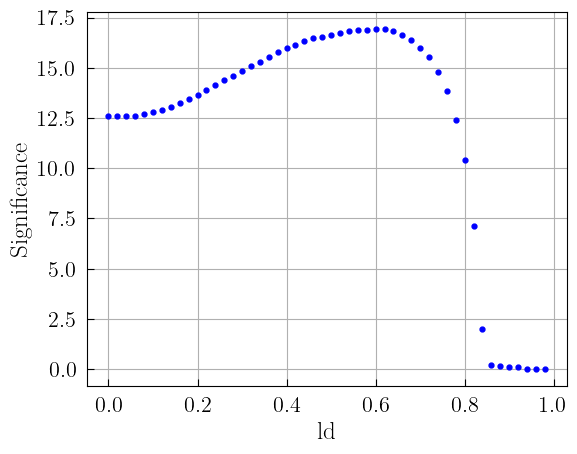

In [54]:
plotCutSignificance(Higgs350, ZJets, 'ld', r=[0,1], ns=50, mode=1, Hmass=350, Hwidth=50, lumH=lumH350)

Discriminante en PSEUDORAPIDITY LEPTON PRIMARIO (centrado)


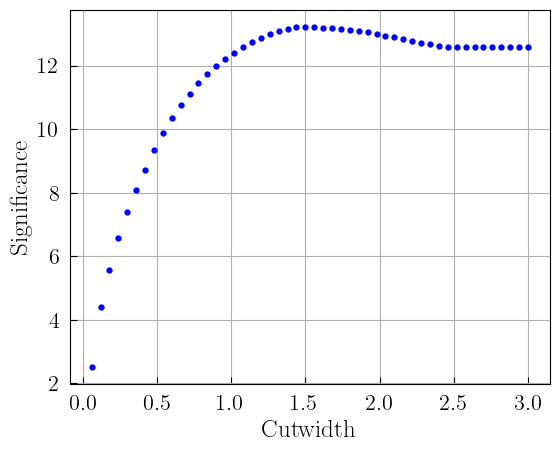

In [23]:
plotCutSignificanceCentral(Higgs350, ZJets, 'etal1', central=0, width=3, ns=50, Hmass=350, Hwidth=50, lumH=lumH350)

Discriminante en MOMENTO TRANSVERSO LETPON SECUNDARIO

ptl2 óptima :  46.0


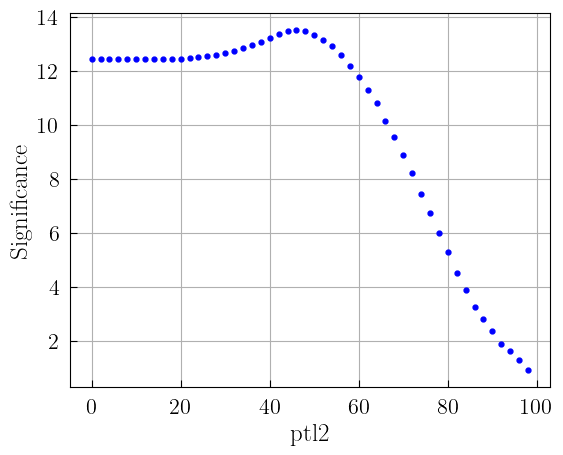

In [56]:
plotCutSignificance(Higgs350, ZJets, 'ptl2', r=[0,100], ns=50, mode=1, Hmass=350, Hwidth=50, lumH=lumH350)

Discriminante en MOMENTO TRANSVERSO JET PRIMARIO

ptj1 óptima :  64.0


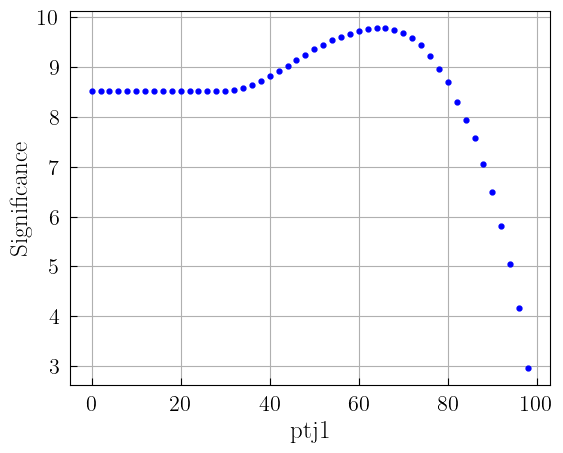

In [63]:
plotCutSignificance(Higgs350, ZJets, 'ptj1', r=[0,100], ns=50, mode=1, Hmass=350, Hwidth=50, lumH=lumH350)

Discriminante en Z HADRÓNICO (centrado)

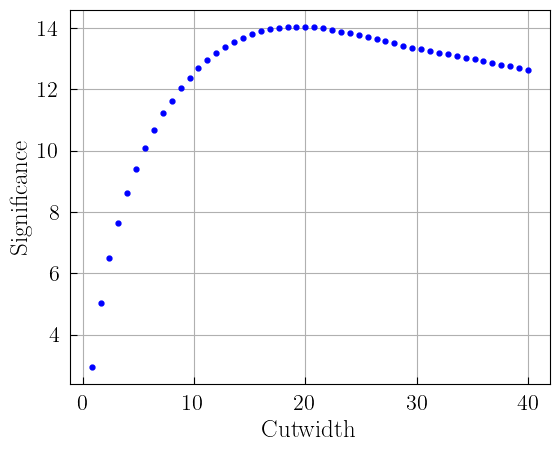

In [24]:
plotCutSignificanceCentral(Higgs350, ZJets, 'massjj', central=90, width=40, ns=50, Hmass=350, Hwidth=50, lumH=lumH350)

La ruth dice de cortar en etal1 1 menor, en valor absoluta.

In [102]:
# Cortes

# corte optimo
Mycuts1 = lambda row: (row.ptl1>68) & (row.ld>0.7) & (row.massjj>70) & (row.massjj<110) & (row.ptj1>64) & (row.etal1<1.5) & (row.etal1>-1.5)

# relajamos corte optimo
Mycuts2 = lambda row: (row.ptl1>40) & (row.ld>0.7) & (row.massjj>70) & (row.massjj<110) & (row.ptj1>30) & (row.etal1<2) & (row.etal1>-2)

# relajamos mas corte optimo
Mycuts3 = lambda row: (row.ptl1>30) & (row.ld>0.73) & (row.massjj>60) & (row.massjj<120) & (row.ptj1>30) & (row.etal1<1) & (row.etal1>-1)

# mas conservador
Mycuts4 = lambda row: (row.ptl1>68) & (row.ld>0.74) & (row.massjj>70) & (row.massjj<110) & (row.ptj1>70) & (row.etal1<1.5) & (row.etal1>-1.5)


In [103]:
N_c = {} # numero de eventos de señal tras cada corte
event_hits_sim = {}

## Corte 1 : 
- $pT_{l1} > 68$
- $ld > 0.6$
- $pT_{j1} > 64$ 
- $|\eta_{l1}| < 1.5$
- $|M_{jj} - 90| < 20$ 

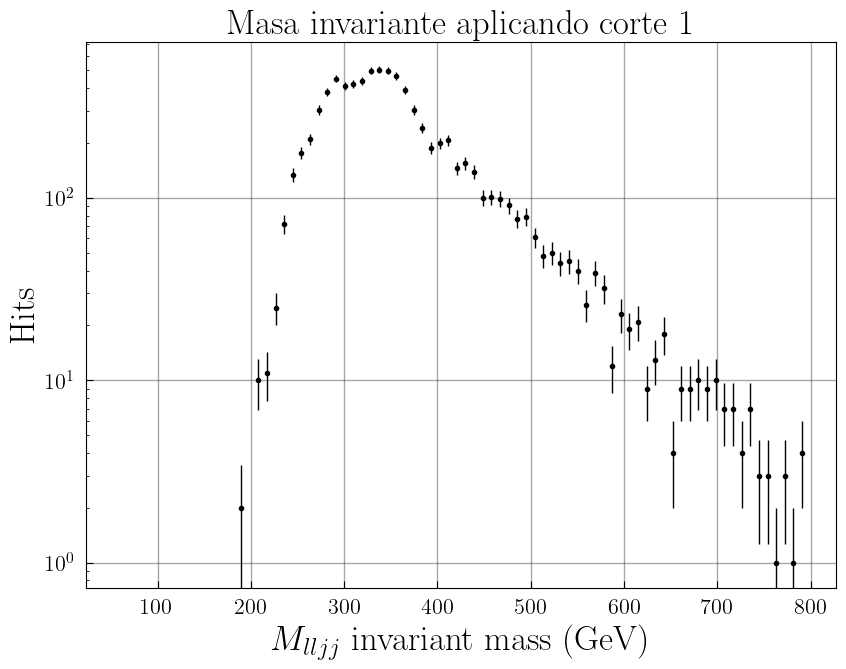

In [104]:
# Select Mlljj values that verify selections cuts

DataSel1 = Data.loc[Data.apply(Mycuts1, axis=1), 'masslljj']

# Plot the histrogram for Mlljj of the selected events
figure_features()
fig = plt.figure(figsize=(10,7))
plot_data(DataSel1, r'$M_{lljj}$'+' invariant mass (GeV)', [60,800], l=1)
plt.grid(linewidth=1, color='black', alpha=0.35)
plt.title("Masa invariante aplicando corte 1",fontsize=25)
plt.savefig("Images/Real_data/Data_cut1.png")
plt.show()


Una vez vemos que Higgs se encuentra en 350, comparamos con las simulaciones:

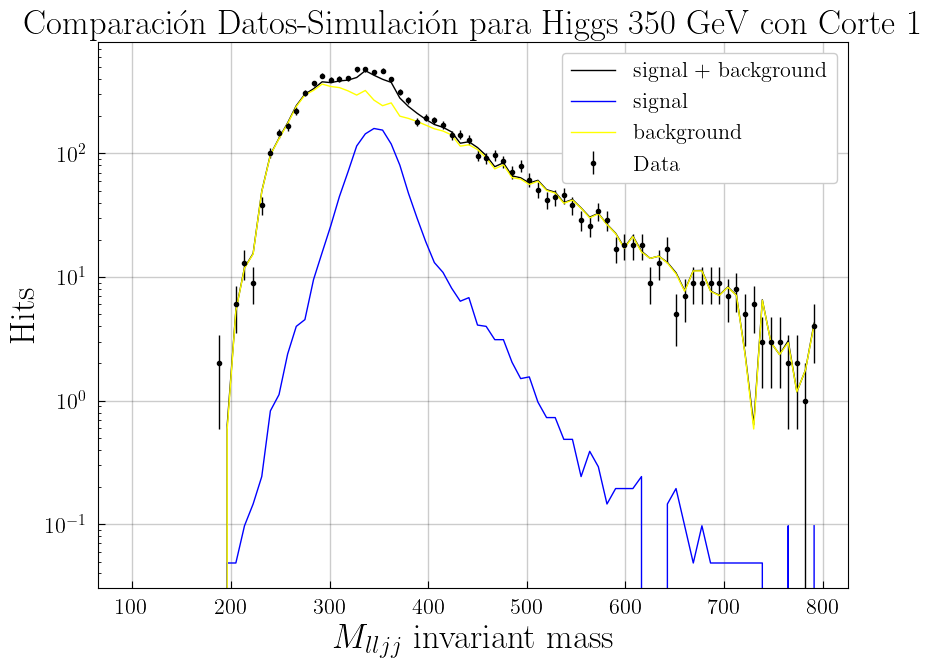

In [105]:
DataSel  = Data.loc[Data.apply(Mycuts1, axis=1), 'masslljj']
HiggsSel = Higgs350.loc[Higgs350.apply(Mycuts1, axis=1), 'masslljj']
ZJetsSel = ZJets.loc[ZJets.apply(Mycuts1, axis=1), 'masslljj']

figure_features()
plt.figure(figsize=(10,7))
x1, x2 = compare_data_sim(DataSel, ZJetsSel, HiggsSel, lumH350, r'$M_{lljj}$'+' invariant mass', (100,800), l=1)
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.title("Comparación Datos-Simulación para Higgs 350 GeV con Corte 1",fontsize=25)
plt.savefig("Images/Real_data/Comparison_simulations_data_H350_cut1.png")
plt.show(fig)

N_c['Cut1'] = x1
event_hits_sim['Cut1'] = x2


Create residual plot: background fit vs data

## Corte 2 : 
- $pT_{l1} > 40$
- $ld > 0.7$
- $pT_{j1} > 30$ 
- $|\eta_{l1}| < 2$
- $|M_{jj} - 90| < 20$ 

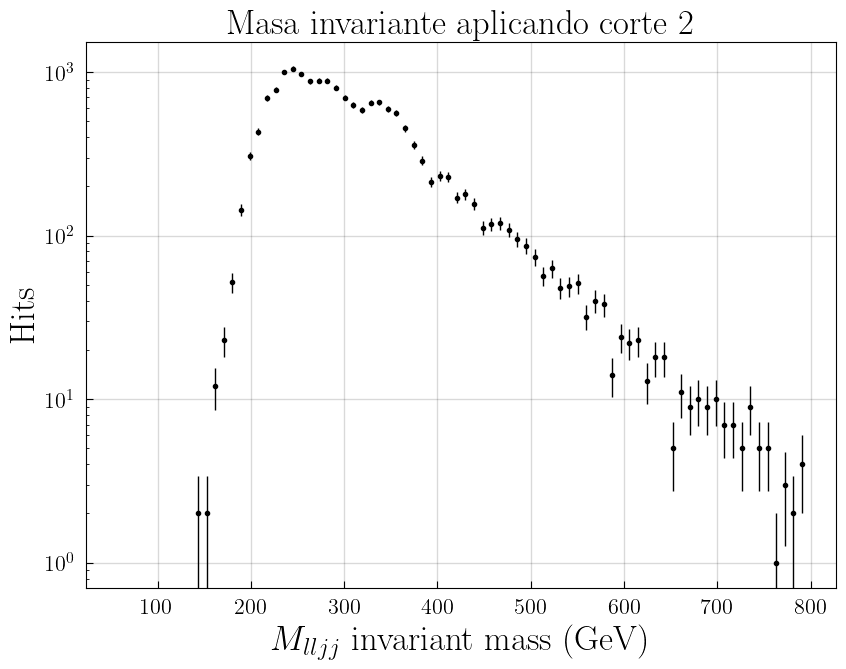

In [106]:
# Select Mlljj values that verify selections cuts

DataSel2 = Data.loc[Data.apply(Mycuts2, axis=1), 'masslljj']

# Plot the histrogram for Mlljj of the selected events
figure_features()
plt.figure(figsize=(10,7))
plot_data(DataSel2, r'$M_{lljj}$'+' invariant mass (GeV)', [60,800], l=1)
plt.grid(linewidth=1, color='black', alpha=0.15)
plt.title("Masa invariante aplicando corte 2",fontsize=25)
plt.savefig("Images/Real_data/Data_cut2.png")
plt.show()


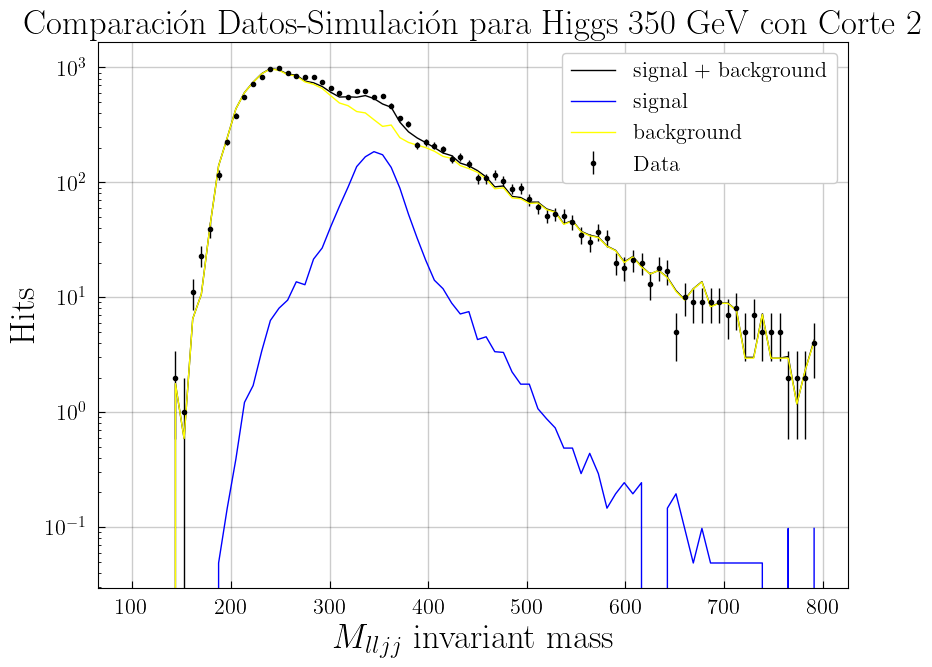

In [107]:
DataSel  = Data.loc[Data.apply(Mycuts2, axis=1), 'masslljj']
HiggsSel = Higgs350.loc[Higgs350.apply(Mycuts2, axis=1), 'masslljj']
ZJetsSel = ZJets.loc[ZJets.apply(Mycuts2, axis=1), 'masslljj']

figure_features()
plt.figure(figsize=(10,7))
x1, x2 = compare_data_sim(DataSel, ZJetsSel, HiggsSel, lumH350, r'$M_{lljj}$'+' invariant mass', (100,800), l=1)
plt.title("Comparación Datos-Simulación para Higgs 350 GeV con Corte 2",fontsize=25)
plt.yscale("log")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.savefig("Images/Real_data/Comparison_simulations_data_H350_cut2.png")
plt.show()

N_c['Cut2'] = x1
event_hits_sim['Cut2'] = x2




## Corte 3 : 
- $pT_{l1} > 30$
- $ld > 0.73$
- $pT_{j1} > 30$ 
- $|\eta_{l1}| < 1$
- $|M_{jj} - 90| < 30$ 

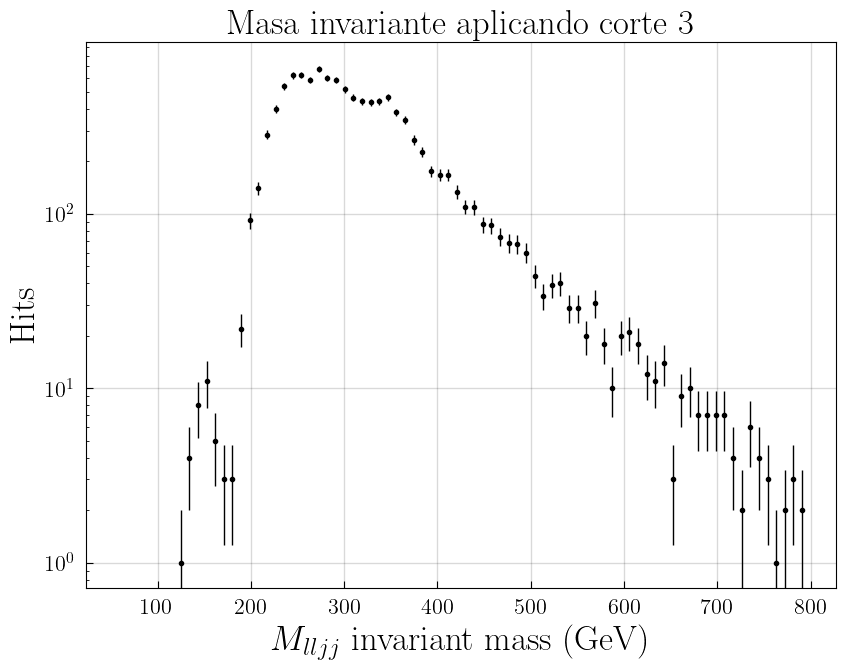

In [108]:
# Select Mlljj values that verify selections cuts

DataSel3 = Data.loc[Data.apply(Mycuts3, axis=1), 'masslljj']

# Plot the histrogram for Mlljj of the selected events
figure_features()
plt.figure(figsize=(10,7))
plot_data(DataSel3, r'$M_{lljj}$'+' invariant mass (GeV)', [60,800], l=1)
plt.grid(linewidth=1, color='black', alpha=0.15)
plt.title("Masa invariante aplicando corte 3",fontsize=25)
plt.savefig("Images/Real_data/Data_cut3.png")
plt.show()


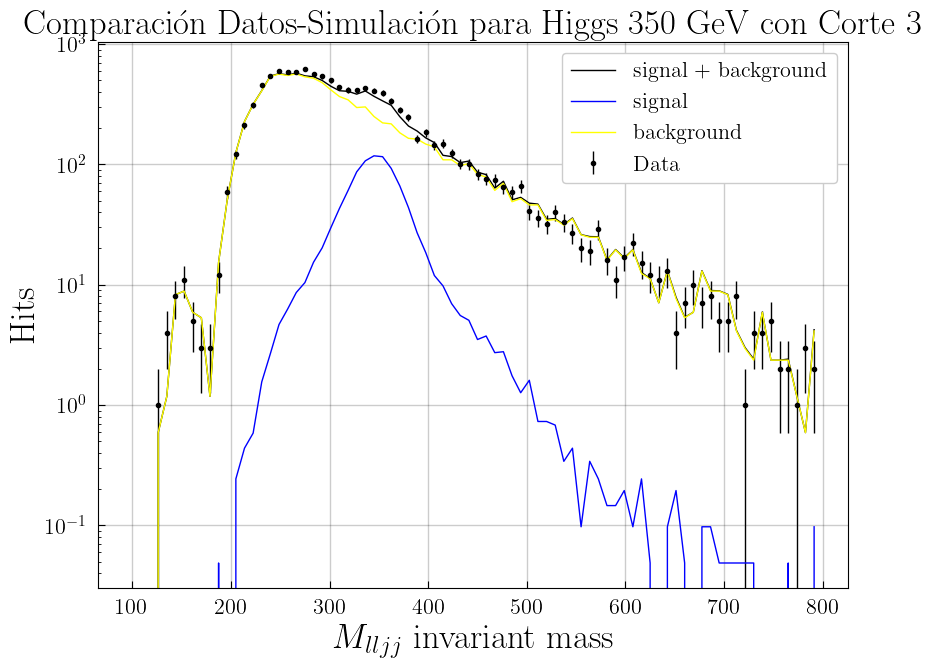

In [109]:
DataSel  = Data.loc[Data.apply(Mycuts3, axis=1), 'masslljj']
HiggsSel = Higgs350.loc[Higgs350.apply(Mycuts3, axis=1), 'masslljj']
ZJetsSel = ZJets.loc[ZJets.apply(Mycuts3, axis=1), 'masslljj']

figure_features()
plt.figure(figsize=(10,7))
x1, x2 = compare_data_sim(DataSel, ZJetsSel, HiggsSel, lumH350, r'$M_{lljj}$'+' invariant mass', (100,800), l=1)
plt.title("Comparación Datos-Simulación para Higgs 350 GeV con Corte 3",fontsize=25)
plt.yscale("log")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.savefig("Images/Real_data/Comparison_simulations_data_H350_cut3.png")
plt.show()

N_c['Cut3'] = x1
event_hits_sim['Cut3'] = x2


## Corte 4 : 
- $pT_{l1} > 68$
- $ld > 0.74$
- $pT_{j1}> 70$ 
- $|\eta_{l1}| < 1.5$
- $|M_{jj} - 90| < 20$ 

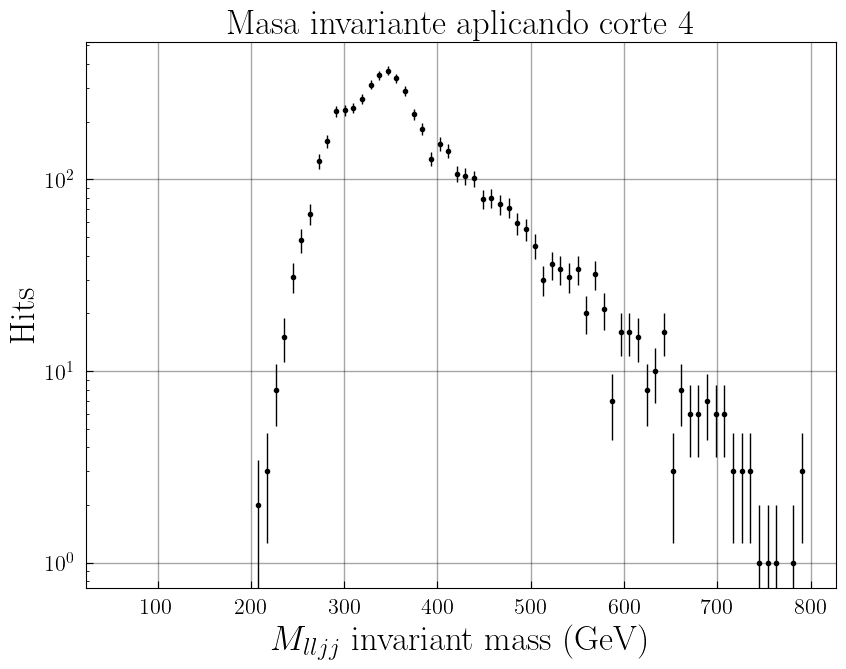

In [110]:
# Select Mlljj values that verify selections cuts

DataSel4 = Data.loc[Data.apply(Mycuts4, axis=1), 'masslljj']

# Plot the histrogram for Mlljj of the selected events
figure_features()
plt.figure(figsize=(10,7))
plot_data(DataSel4, r'$M_{lljj}$'+' invariant mass (GeV)', [60,800], l=1)
plt.grid(linewidth=1, color='black', alpha=0.35)
plt.title("Masa invariante aplicando corte 4",fontsize=25)
plt.savefig("Images/Real_data/Data_cut4.png")
plt.show()


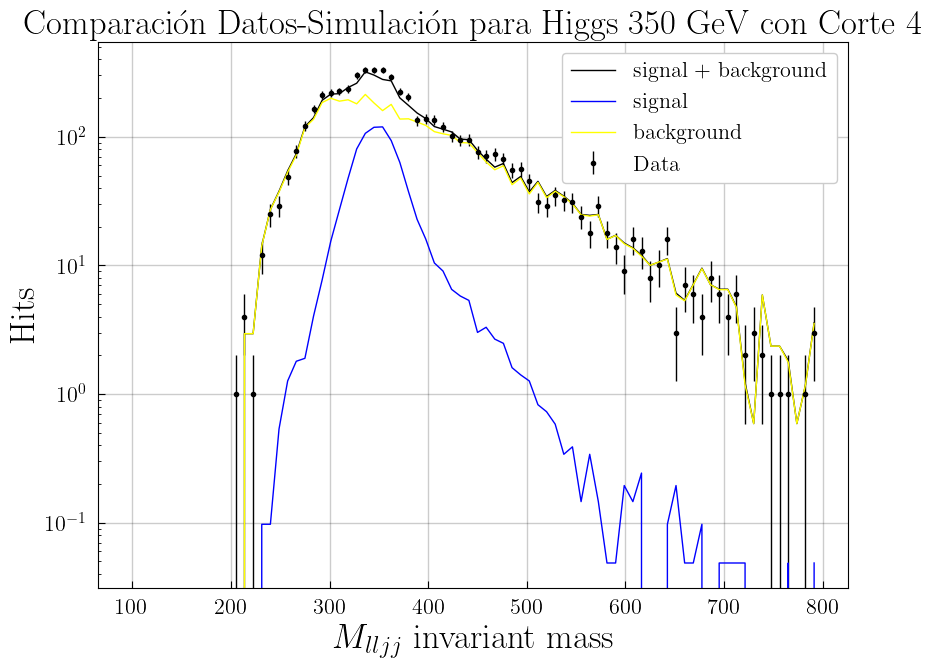

In [111]:
DataSel  = Data.loc[Data.apply(Mycuts4, axis=1), 'masslljj']
HiggsSel = Higgs350.loc[Higgs350.apply(Mycuts4, axis=1), 'masslljj']
ZJetsSel = ZJets.loc[ZJets.apply(Mycuts4, axis=1), 'masslljj']

figure_features()
plt.figure(figsize=(10,7))
x1, x2 = compare_data_sim(DataSel, ZJetsSel, HiggsSel, lumH350, r'$M_{lljj}$'+' invariant mass', (100,800), l=1)
plt.title("Comparación Datos-Simulación para Higgs 350 GeV con Corte 4",fontsize=25)
plt.yscale("log")
plt.grid(linewidth=1, color='black', alpha=0.2)
plt.savefig("Images/Real_data/Comparison_simulations_data_H350_cut4.png")
plt.show()

N_c['Cut4'] = x1
event_hits_sim['Cut4'] = x2


Ajustamos a Gaussianas suprimidas por exponenciales:

In [114]:
# Fit function (exponential + gaussian)
def exp_gauss(x, a, b, c, m, s):
    return a*np.exp(b*x) + c*np.exp(-0.5*(x-m)**2/s**2)


In [115]:
param_EXP_GAUSS = {}

## HAY PROBLEMAS PARA AJUSTAR LA PARTE EXPONENCIAL, LA GAUSSIANA ESTÁ

Parámetros del ajuste Corte 1 :  [ 6.10964394e+03 -8.84865108e-03  2.36435212e+02  3.46286305e+02
  2.07845925e+01]
Errores del ajuste de Corte 1 :  [6.55976331e+02 2.72698901e-04 1.08390087e+01 1.11408521e+00
 1.39956021e+00]


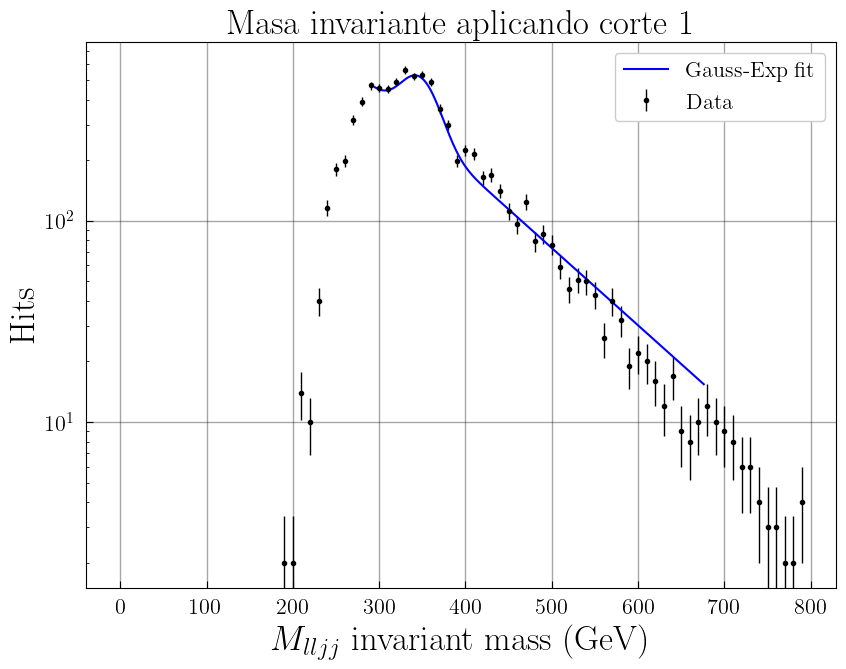

In [120]:
# CORTE 1

n, f = 0, 40

#[1, 0, 0.1, 350, 10]

y, x = get_data(DataSel1, nb=53, r=[295,800])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=exp_gauss, xdata=x[n:f], ydata=y[n:f], p0=[1, 0, 0.1, 350, 10], bounds=(-np.inf, np.inf), maxfev=10000000)
print("Parámetros del ajuste Corte 1 : ", params)
print("Errores del ajuste de Corte 1 : ",np.sqrt(np.diag(cov)))
param_EXP_GAUSS['Cut1']=[params],[np.sqrt(np.diag(cov))]

figure_features()
plt.figure(figsize=(10,7))
plot_data(DataSel1, r'$M_{lljj}$'+' invariant mass (GeV)', (0,800), l=1)
x_aux = np.linspace(x[n],x[f],1000)
plt.plot(x_aux, exp_gauss(x_aux,*params), label='Gauss-Exp fit', linewidth=1.5, color='blue')

#x_aux2 = np.linspace(params[3]-3*params[4], params[3]+10*params[4], 100)
#plt.plot(x_aux2, exp_gauss(x_aux2,0, 0, params[2], params[3], params[4]), label='Gauss', linewidth=1, color='green') 
#plt.plot(x_aux2, exp_gauss(x_aux2,params[0], params[1], 0, 0, 0), label='Exp', linewidth=1, color='red') 

plt.title("Masa invariante aplicando corte 1",fontsize=25)
plt.grid(linewidth=1, color='black', alpha=0.35)
plt.legend()
#plt.savefig("Images/Real_data/Fit_cut1_Gauss_Exp_Fit.png")
plt.savefig("Images/Real_data/Fit_cut1.png")
plt.show()


Parámetros del ajuste Corte 2 :  [ 2.00146659e+04 -1.10860659e-02  2.12620652e+02  3.47587484e+02
  1.68074800e+01]
Errores del ajuste de Corte 2 :  [1.35316090e+03 2.21406810e-04 1.40200726e+01 1.23322165e+00
 1.38491362e+00]


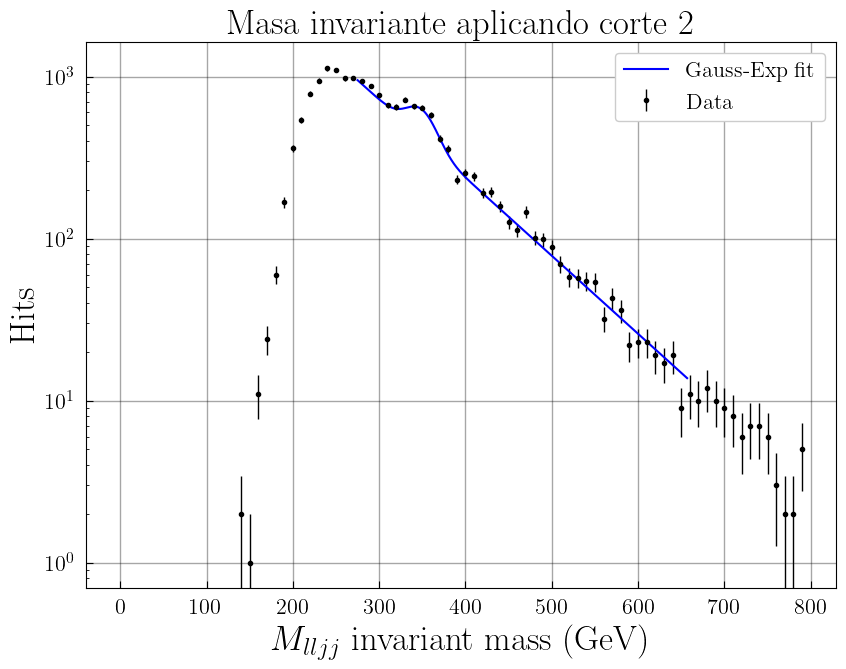

In [121]:
# CORTE 2

n, f = 0, 40

y, x = get_data(DataSel2, nb=55, r=[275,800])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=exp_gauss, xdata=x[n:f], ydata=y[n:f], p0=[1000, 0, 100, 350, 10], bounds=(-np.inf, np.inf), maxfev=1000000000)
print("Parámetros del ajuste Corte 2 : ", params)
print("Errores del ajuste de Corte 2 : ",np.sqrt(np.diag(cov)))
param_EXP_GAUSS['Cut2']=[params],[np.sqrt(np.diag(cov))]

figure_features()
plt.figure(figsize=(10,7))
plot_data(DataSel2, r'$M_{lljj}$'+' invariant mass (GeV)', (0,800), l=1)
x_aux = np.linspace(x[n],x[f],1000)
plt.plot(x_aux, exp_gauss(x_aux,*params), label='Gauss-Exp fit', linewidth=1.5, color='blue')  

#x_aux2 = np.linspace(params[3]-3*params[4], params[3]+10*params[4], 100)
#plt.plot(x_aux2, exp_gauss(x_aux2,0, 0, params[2], params[3], params[4]), label='Gauss', linewidth=1, color='green') 
#plt.plot(x_aux2, exp_gauss(x_aux2,params[0], params[1], 0, 0, 0), label='Exp', linewidth=1, color='red') 

plt.title("Masa invariante aplicando corte 2",fontsize=25)
plt.grid(linewidth=1, color='black', alpha=0.35)
plt.legend()
#plt.savefig("Images/Real_data/Fit_cut2_Gauss_Exp_Fit.png")
plt.savefig("Images/Real_data/Fit_cut2.png")
plt.show()


Parámetros del ajuste Corte 3 :  [ 1.54898776e+04 -1.12198007e-02  1.44899872e+02  3.49503115e+02
  1.87352455e+01]
Errores del ajuste de Corte 3 :  [7.47403531e+02 1.56151883e-04 6.58622010e+00 9.47801315e-01
 1.08403279e+00]


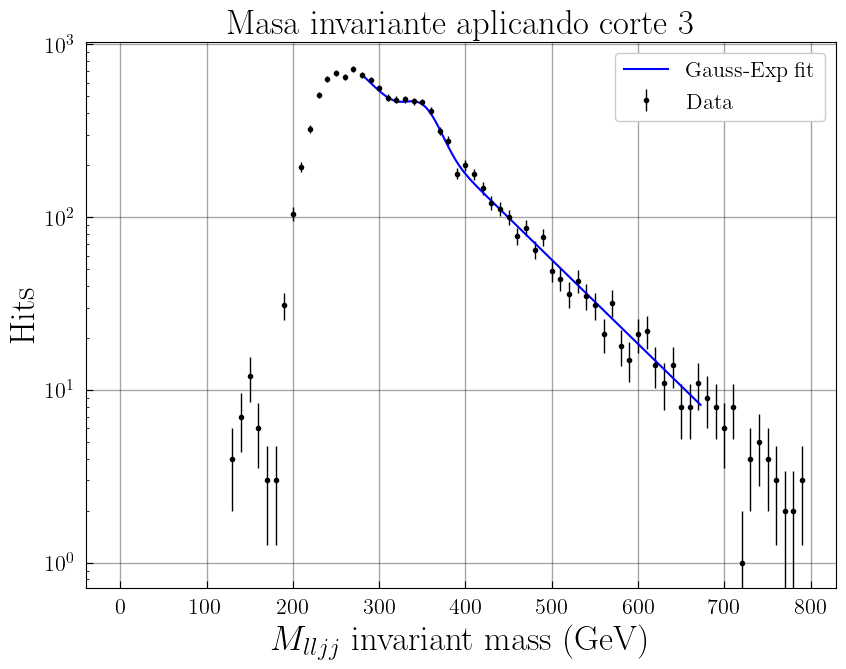

In [122]:
# CORTE 3

n, f = 0, 40

y, x = get_data(DataSel3, nb=53, r=[280,800])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=exp_gauss, xdata=x[n:f], ydata=y[n:f], p0=[1000, 0, 100, 350, 10], bounds=(-np.inf, np.inf), maxfev=10000000)
print("Parámetros del ajuste Corte 3 : ", params)
print("Errores del ajuste de Corte 3 : ",np.sqrt(np.diag(cov)))
param_EXP_GAUSS['Cut3']=[params],[np.sqrt(np.diag(cov))]

figure_features()
plt.figure(figsize=(10,7))
plot_data(DataSel3, r'$M_{lljj}$'+' invariant mass (GeV)', (0,800), l=1)
x_aux = np.linspace(x[n],x[f],1000)
plt.plot(x_aux, exp_gauss(x_aux,*params), label='Gauss-Exp fit', linewidth=1.5, color='blue')  

#x_aux2 = np.linspace(params[3]-3*params[4], params[3]+10*params[4], 100)
#plt.plot(x_aux2, exp_gauss(x_aux2,0, 0, params[2], params[3], params[4]), label='Gauss', linewidth=1, color='green') 
#plt.plot(x_aux2, exp_gauss(x_aux2,params[0], params[1], 0, 0, 0), label='Exp', linewidth=1, color='red') 

plt.title("Masa invariante aplicando corte 3",fontsize=25)
plt.grid(linewidth=1, color='black', alpha=0.35)
plt.legend()
#plt.savefig("Images/Real_data/Fit_cut3_Gauss_Exp_Fit.png")
plt.savefig("Images/Real_data/Fit_cut3.png")
plt.show()


Parámetros del ajuste Corte 4 :  [ 2.13110930e+03 -7.39641410e-03  1.93208469e+02  3.49256762e+02
  2.03783031e+01]
Errores del ajuste de Corte 4 :  [3.87858628e+02 4.25391729e-04 1.02485588e+01 1.21619443e+00
 1.58763681e+00]


/tmp/ipykernel_6122/3554447850.py:3: RuntimeWarning: divide by zero encountered in divide
  return a*np.exp(b*x) + c*np.exp(-0.5*(x-m)**2/s**2)


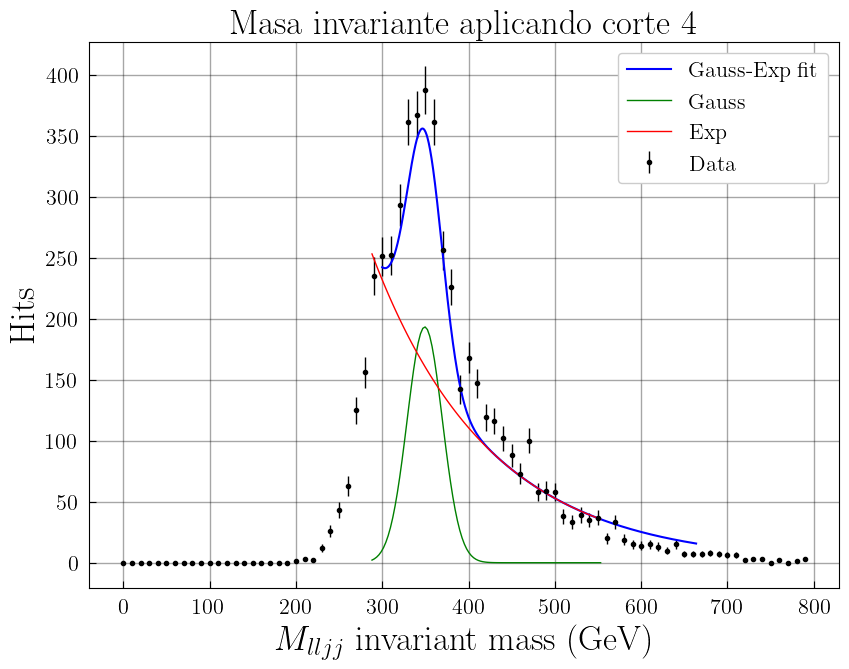

In [119]:
# CORTE 4

n, f = 0, 40

y, x = get_data(DataSel4, nb=55, r=[300,800])
x = x[:-1] # remove right edge of last bin 
params, cov = scipy.optimize.curve_fit(f=exp_gauss, xdata=x[n:f], ydata=y[n:f], p0=[100, 0, 1200, 350, 10], bounds=(-np.inf, np.inf), maxfev=1000000000)
print("Parámetros del ajuste Corte 4 : ", params)
print("Errores del ajuste de Corte 4 : ",np.sqrt(np.diag(cov)))
param_EXP_GAUSS['Cut4']=[params],[np.sqrt(np.diag(cov))]

figure_features()
plt.figure(figsize=(10,7))
plot_data(DataSel4, r'$M_{lljj}$'+' invariant mass (GeV)', (0,800), l=0)
x_aux = np.linspace(x[n],x[f],1000)
plt.plot(x_aux, exp_gauss(x_aux,*params), label='Gauss-Exp fit', linewidth=1.5, color='blue')  

x_aux2 = np.linspace(params[3]-3*params[4], params[3]+10*params[4], 100)
plt.plot(x_aux2, exp_gauss(x_aux2,0, 0, params[2], params[3], params[4]), label='Gauss', linewidth=1, color='green') 
plt.plot(x_aux2, exp_gauss(x_aux2,params[0], params[1], 0, 0, 0), label='Exp', linewidth=1, color='red') 

plt.title("Masa invariante aplicando corte 4",fontsize=25)
plt.grid(linewidth=1, color='black', alpha=0.35)
plt.legend()
plt.savefig("Images/Real_data/Fit_cut4_Gauss_Exp_Fit.png")
plt.show()


Calculamos numero de eventos segun e ajuste, es decir, area bajo la gaussiana: 

## METODO DE SIMPSON © LUISMA

La masa, anchura y numero de sucesos vendran dados por los parametros de la gaussiana.

In [66]:
list_cuts = ['Cut1', 'Cut2', 'Cut3', 'Cut4']
list_data_cuts = [DataSel1, DataSel2, DataSel3, DataSel4]
event_hits_data = {}
back_hits_data ={}
for i in range(len(list_cuts)):
    
    cuts = list_cuts[i]
    data_set = list_data_cuts[i]
    
    mass = param_EXP_GAUSS[cuts][0][0][3]
    gamma = abs(param_EXP_GAUSS[cuts][0][0][4])

    r = (mass-2*sigma,mass+2*sigma)
    r1 = (287.5,800) # inicio y final del ajuste

    ev = simp_int(exp_gauss, [0, 0, param_EXP_GAUSS[cuts][0][0][2], param_EXP_GAUSS[cuts][0][0][3], param_EXP_GAUSS[cuts][0][0][4]], r[0], r[1], 0.01)
    ev = ev / ((r1[1]-r1[0])/54)
    event_hits_data[cuts] = ev

       

    nb = float(data_set.value_counts(bins=[r[0],r[1]])) - ev
    back_hits_data[cuts] = nb

    sigma = ev/np.sqrt(nb)

    print('Para el corte ' + cuts + ' :' +
          'Masa Higgs = ',mass,' GeV, '+
            'Anchura = ',gamma,' GeV, '+ 
                'y número de señales ', ev,
                 ' y numero de eventos de fondo', nb,
                  'y significancia ', sigma)
                
    print("")
    


Para el corte Cut1 :Masa Higgs =  346.28630503126436  GeV, Anchura =  20.784592465310396  GeV, y número de señales  1283.7175381123286  y numero de eventos de fondo 3383.282461887671 y significancia  22.069899007695525

Para el corte Cut2 :Masa Higgs =  347.58748440377514  GeV, Anchura =  16.807480016208814  GeV, y número de señales  935.6884102549188  y numero de eventos de fondo 4282.311589745081 y significancia  14.2985539404682

Para el corte Cut3 :Masa Higgs =  349.50311539810997  GeV, Anchura =  18.735245461076893  GeV, y número de señales  625.9990823258835  y numero de eventos de fondo 1894.0009176741164 y significancia  14.384130151415114

Para el corte Cut4 :Masa Higgs =  349.2567623222631  GeV, Anchura =  20.378303055722558  GeV, y número de señales  875.5439808101655  y numero de eventos de fondo 1098.4560191898345 y significancia  26.417190633660677



Con ello se tiene ya ANCHURA DE LA GAUSSIANA (anchura estadistica), MASA DEL HIGSS, y NUMERO DE EVENTOS DE SEÑAL EN LOS DATOS SEGUN AJUSTE

- N_c es numero de eventos totales de señal en la simulación Higgs 350 tras cada tipo de corte.
- events_hits son numero de eventos en el pico de masa de los datos, es la constante C del ajuste de la gaussiana

In [67]:
print("Numero total de eventos de señal",N_c) # eventos de señal segun simulación
print("Numero de eventos en 2 sigmas de datos",event_hits_data)
print("Numero de eventos en 2 sigmas de simulación",event_hits_sim) # eventos de señal en el maximo segun la simulación

Numero total de eventos de señal {'Cut1': 8145, 'Cut2': 16941, 'Cut3': 10987, 'Cut4': 5065}
Numero de eventos en 2 sigmas de datos {'Cut1': 1283.7175381123286, 'Cut2': 935.6884102549188, 'Cut3': 625.9990823258835, 'Cut4': 875.5439808101655}
Numero de eventos en 2 sigmas de simulación {'Cut1': 1092.3041975308472, 'Cut2': 1328.1691358024482, 'Cut3': 913.3017283950492, 'Cut4': 805.1219753086305}


Calculamos la sección eficaz:

In [342]:
L = 19.7 # fb ^ -1
B = 0.014
N_i = 300000


In [344]:
cross_sec_data = {}
cross_sec_sim = {}
for cuts in list_cuts:
    epsilon = N_c[cuts] / N_i
    print(epsilon)
    cross_sec_data[cuts] = cross_section(event_hits_data[cuts]) / 1000
    cross_sec_sim[cuts] = cross_section(event_hits_sim[cuts]) / 1000



0.02715
0.05647
0.036623333333333334
0.016883333333333334


Secciones eficaces en $\textbf{pb}$ según los datos existentes.

In [345]:
cross_sec_data

{'Cut1': 158.38593579406677,
 'Cut2': 59.50918910442514,
 'Cut3': 67.12722491571037,
 'Cut4': 213.48230632054452}

In [346]:
cross_sec_sim

{'Cut1': 118.44186552596389,
 'Cut2': 66.69583731150368,
 'Cut3': 68.26730773212851,
 'Cut4': 140.99249439821733}

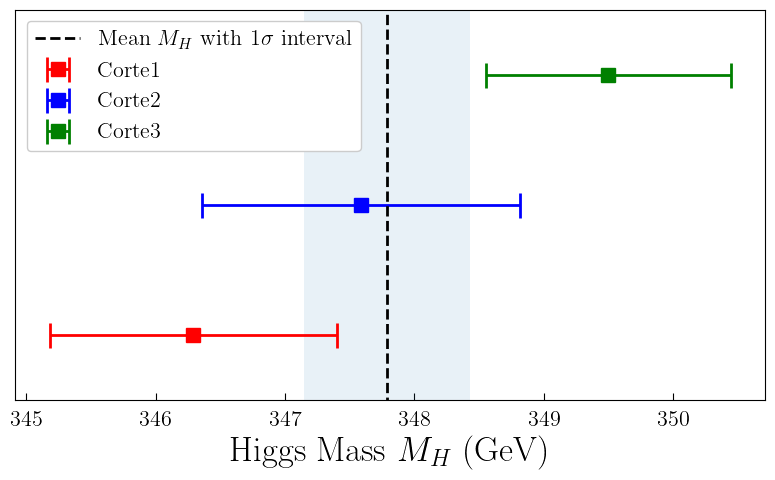

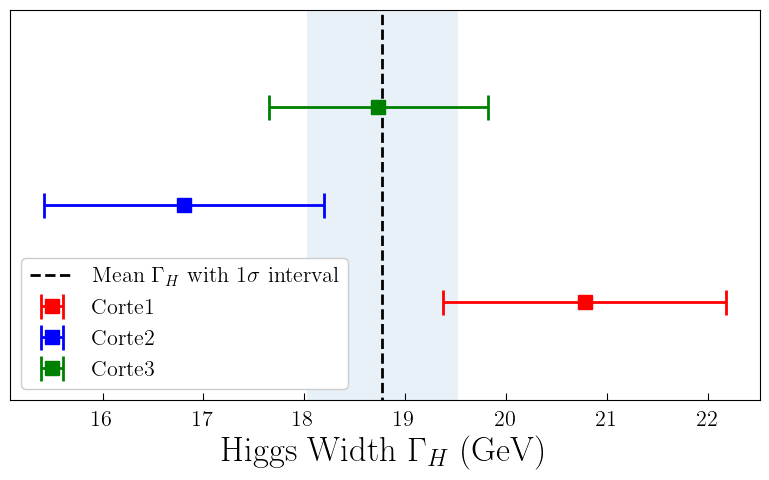

In [123]:
# we plot all results for mass and width

M = [346.29,347.59,349.50]
deltaM = [1.11,1.23,0.95]

meanM = 347.79
meanerrM = 0.64

sigma = [20.78,16.81,18.735]
deltasigma = [1.40,1.39,1.084]

meanSigma = 18.775
meanerrSig = 0.75

figure_features()
plt.figure(figsize=(10,5))
plt.errorbar(M[0],2,xerr=deltaM[0],fmt='sr',capsize=9, linewidth=2, capthick=2, markersize=10,label='Corte1')
plt.errorbar(M[1],2.2,xerr=deltaM[1],fmt='sb',capsize=9, linewidth=2, capthick=2, markersize=10,label='Corte2')
plt.errorbar(M[2],2.4,xerr=deltaM[2],fmt='sg',capsize=9, linewidth=2, capthick=2, markersize=10,label='Corte3')

plt.vlines(meanM, ymin=1, ymax=3, color='black', linestyles='dashed', linewidth=2, label='Mean '+r'$M_H$'+' with '+r'$1\sigma$'+' interval')
plt.fill_betweenx(np.linspace(1,3,100), x1=meanM-meanerrM, x2=meanM+meanerrM, alpha=0.1)

plt.legend()
plt.ylim(1.9,2.5)
plt.yticks([])

plt.xlabel('Higgs Mass '+r'$M_{H}$'+' (GeV)',fontsize=25)
plt.savefig("Images/Comparativas_masas_H.png")
plt.show()

figure_features()
plt.figure(figsize=(10,5))
plt.errorbar(sigma[0],2,xerr=deltasigma[0],fmt='sr',capsize=9, linewidth=2, capthick=2, markersize=10,label='Corte1')
plt.errorbar(sigma[1],2.01,xerr=deltasigma[1],fmt='sb',capsize=9, linewidth=2, capthick=2, markersize=10,label='Corte2')
plt.errorbar(sigma[2],2.02,xerr=deltasigma[2],fmt='sg',capsize=9, linewidth=2, capthick=2, markersize=10,label='Corte3')

plt.vlines(meanSigma, ymin=1, ymax=3, color='black', linestyles='dashed', linewidth=2, label='Mean '+r'$\Gamma_H$'+' with '+r'$1\sigma$'+' interval')
plt.fill_betweenx(np.linspace(1,3,100), x1=meanSigma-meanerrSig, x2=meanSigma+meanerrSig, alpha=0.1)

plt.legend()
plt.ylim(1.99,2.03)
plt.yticks([])
plt.xlabel('Higgs Width '+r'$\Gamma_H$'+' (GeV)',fontsize=25)
plt.savefig("Images/Comparativas_width_H.png")
plt.show()
